# Project: SkimLit


The purpose of this notebook is to build an NLP model to make reading medical abstracts easier.

The paper we are replicating(the source of the dataset that we will be using) is available : https://arxiv.org/abs/1710.06071

And reading through the paper above, we see that the model architecture that they use to acheive their best results is available here: https://aclanthology.org/E17-2110/



## Confirm access to a GPU

In [1]:
!pip uninstall tensorflow -y 
!pip uninstall tensorflow-hub -y
!pip uninstall keras -y


Found existing installation: tensorflow 2.15.0
Uninstalling tensorflow-2.15.0:
  Successfully uninstalled tensorflow-2.15.0
Found existing installation: tensorflow-hub 0.16.1
Uninstalling tensorflow-hub-0.16.1:
  Successfully uninstalled tensorflow-hub-0.16.1
Found existing installation: keras 3.2.1
Uninstalling keras-3.2.1:
  Successfully uninstalled keras-3.2.1


In [2]:
!pip install tensorflow==2.15

!pip install keras==2.15

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 31.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.
tensorflow-text 2.15.0 requires tensorflow-hub>=0.13.0, which is not installed.


In [3]:
!pip install tensorflow-hub==0.15

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.4/85.4 kB 879.1 kB/s eta 0:00:00


In [4]:
## Check for GPU
import tensorflow as tf
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

2024-05-19 15:16:07.832039: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-19 15:16:07.832087: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-19 15:16:07.833547: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


GPU is available


In [5]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

## Get data

Since we will be replicating the paper above(PubMed 200k RCT). Let's download the dataset they used.

We can do so from the author's GitHub: https://github.com/Franck-Dernoncourt/pubmed-rct

In [6]:
! git clone https://github.com/Franck-Dernoncourt/pubmed-rct


Cloning into 'pubmed-rct'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 39 (delta 8), reused 5 (delta 5), pack-reused 25
Unpacking objects: 100% (39/39), 177.08 MiB | 15.06 MiB/s, done.


In [7]:
# check what files are in the PubMed 20k dataset
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

dev.txt  test.txt  train.txt


In [8]:
# Start our experiments using the 20k dataset with numbers replaced by @ sign.
data_dir = "pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [9]:
# check all the file names in the target directory
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt']

## Preprocess the data

Now we have some text data, it is time to become one with it. And one of the best ways to become one with the data is to visualize it.

So with that in mind, let's create a function to read in all the lines of a target text file.


In [10]:
# Create a function to read the lines of a document
def get_lines(filename):
    """
    Reads file name (a text file name) and returns the lines of the text file as a list

    Args:
    filename: a string containing the target filepath.
    Returns:
    A list of string with one string per line from the target filename.
    """
    with open(filename,"r") as f:
        return f.readlines()

In [11]:
# Let's read in the training files
train_lines = get_lines(data_dir+"train.txt")
train_lines[:30]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [12]:
len(train_lines)

210040

```[{'line_number':0,
    'target':'BACKGROUND',
    'text':'Emotional eating is associated with overeating and the development of obesity .\n',
    'total_lines':11}]```

In [13]:
train_lines[:27]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [14]:
test_list = []
info_dict = dict()
for index,i in enumerate(train_lines[:27]):

    split_text = i.splitlines()


    for j in split_text:

        line_split = j.split('\t')

        if len(line_split) > 1:
            if line_split[0] not in info_dict:
                info_dict[line_split[0]] = line_split[1]
            else:
                info_dict[line_split[0]] = info_dict[line_split[0]] + line_split[1]
        # print(info_dict)
        if "###" in j:
            info_dict["id"] = j.split('###')[1]

        if j == '':

            test_list.append(info_dict)
            info_dict = dict()
            print("===============================")
print(test_list)
print(len(test_list))

[{'id': '24293578', 'OBJECTIVE': 'To investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .', 'METHODS': 'A total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .Outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .Pain was assessed using the visual analog pain scale ( @-@ mm ) .Secondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .Serum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and high-sensitivity C-reactive protein ( hsCRP ) were measured .'

In [15]:
def preprocess_text_with_line_number(filename):
    """
    Returns a list of dictionaries of abstract lines of data.

    Takes in filename, reads it contents and sorts through each line,
    extracting things like the target label, the text of the sentence,
    how many sentences are in the current abstract and what sentence number the target line is
    """
    input_lines = get_lines(filename)
    abstract_lines = "" #create an empty abstract
    abstract_samples = [] # create an empty list of abstracts

    #loop through each line in target file
    for line in input_lines:
        if line.startswith("###"): #check to see if it starts with a ID line
            abstract_id = line
            abstract_lines = "" #reset the abstract string if the line is a 1D line
        elif line.isspace(): #check if the line is a new line
            abstract_line_split = abstract_lines.splitlines() #split abstract into seperate lines

            #iterate through each line in a single abstract and count them at the same time
            for abstract_line_number, abstract_line in enumerate(abstract_line_split):
                line_data = {} # create an empty dictionary for each line
                target_text_split = abstract_line.split("\t") #split target label from text
                line_data["target"] = target_text_split[0] #get target label
                line_data["text"] = target_text_split[1].lower() #get target text and lower the text
                line_data["line_number"] = abstract_line_number #what number line does the line appear in abstract
                line_data["total_lines"] = len(abstract_line_split) - 1 # How many total lines are there in the abstract
                abstract_samples.append(line_data)#add line data to abstract sample
        else: #if the above conditions are not fulfilled, the line containins a labelled sentence
            abstract_lines += line

    return abstract_samples

In [16]:
# Get data from file and process it
%time
train_samples = preprocess_text_with_line_number(data_dir + "train.txt")
val_samples = preprocess_text_with_line_number(data_dir+"dev.txt") #dev is another name for validation
test_samples = preprocess_text_with_line_number(data_dir+"test.txt")
len(train_samples), len(val_samples), len(test_samples)

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 9.3 µs


(180040, 30212, 30135)

In [17]:
# check the first abstract of our training data
train_samples[:14]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

Now that our data is in the form of list of dictionaries, how about we turn it into a dataframe to further visualize it.

In [18]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


In [19]:
# distribution of labels in training data
train_df.target.value_counts()

target
METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: count, dtype: int64

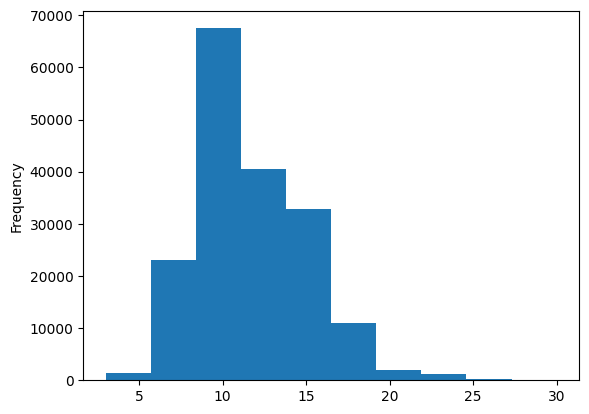

In [20]:
# Let's check the length if differrent lines
train_df.total_lines.plot(kind="hist");

### GET list of sentences

In [21]:
#convert abstract text lines into lists
train_sentences = train_df.text.tolist()
val_sentences = val_df.text.tolist()
test_sentences = test_df.text.tolist()

len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [22]:
# view the 10 lines of train_sentences
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

## Making numeric labels(ML models require numeric labels)


In [23]:
# One hot encode labels
import numpy as np
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse_output=False) #we want non-sparse matrix
train_labels_one_hot = one_hot_encoder.fit_transform(np.expand_dims(train_df["target"].to_numpy(), axis=1))
val_labels_one_hot = one_hot_encoder.transform(np.expand_dims(val_df["target"].to_numpy(), axis=1))
test_labels_one_hot = one_hot_encoder.transform(np.expand_dims(test_df.target.to_numpy(), axis=1))
#check what one hot encoded label looks like
train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

### Label encode labels

In [24]:
# Extract labels(target columns) and encode them into integers
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

#check out the label encoded train labels
train_labels_encoded, val_labels_encoded, test_labels_encoded

(array([3, 2, 2, ..., 4, 1, 1]),
 array([0, 0, 3, ..., 4, 1, 1]),
 array([0, 4, 4, ..., 4, 4, 1]))

In [25]:
# Get the class names and number of classes from label encoder instance
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Model 0: Baseline model

Starting a series of modelling experiments. Let's try a bunch of differrent models and see which one works best. We are going to start a baseline (TF-IDF Multinomial Naive Bayes Classifier)

In [26]:
#creating a tf-idf vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

model_0 = Pipeline([
    ("TFIDF",TfidfVectorizer()),
    ("NB",MultinomialNB())
])

model_0.fit(train_sentences, train_labels_encoded)


Pipeline(steps=[('TFIDF', TfidfVectorizer()), ('NB', MultinomialNB())])

In [27]:
#evaluating the model
model_0.score(val_sentences, val_labels_encoded)

0.7218323844829869

In [28]:
# Make predictions using our baseline model
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [29]:
!wget "https://raw.githubusercontent.com/SangeethKumarPG/DS-DL/main/helper_functions.py"

--2024-05-19 15:16:44--  https://raw.githubusercontent.com/SangeethKumarPG/DS-DL/main/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10128 (9.9K) [text/plain]
Saving to: 'helper_functions.py'

helper_functions.py 100%[===================>]   9.89K  --.-KB/s    in 0s      

2024-05-19 15:16:44 (69.0 MB/s) - 'helper_functions.py' saved [10128/10128]



In [30]:
#importing the calculate results from the helper functions
from helper_functions import calculate_results

base_line_results = calculate_results(val_labels_encoded, baseline_preds)
base_line_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Prepairing our data for deep sequence models

Before we start building deeper models, we have to create vectorization and embedding layers.


In [31]:
#finding the max vocab length
sum([len(i.split()) for i in train_sentences])

4741942

In [32]:
#How long is each sentence on average
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len

26.338269273494777

In [33]:
#finding the max length
round(sum(len(i.split()) for i in train_sentences)/len(train_sentences))

26

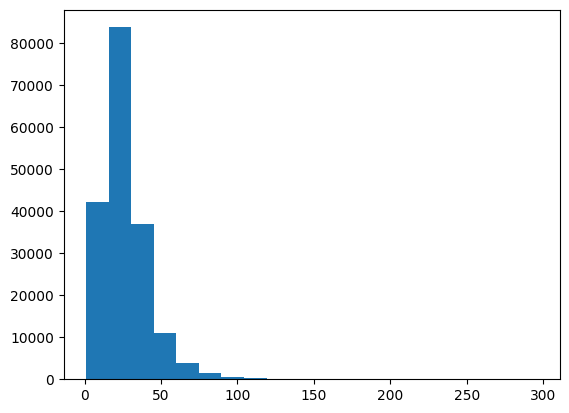

In [34]:
# What does the distribution looks like
import matplotlib.pyplot as plt
plt.hist(sent_lens, bins=20);

In [35]:
# How long of a sentence length covers 95% of example?
output_seq_length = np.percentile(sent_lens, 95)
output_seq_length

55.0

In [36]:
# Maximum sequence length in training set
max(sent_lens)

296

In [37]:
max_vocab_length = 4741942
max_length = 26

### Creating a text vectorizer layer

We want to make a layer which maps our texts from words to numbers

In [38]:
# How many words should be in the vocabulary (taken from table 2 under [V]
max_tokens=68000


In [39]:
from tensorflow.keras import layers

#creating a text vectorizer instance
text_vectorizer = layers.TextVectorization(max_tokens=max_tokens,
                                           output_mode="int",
                                           output_sequence_length=int(output_seq_length),
                                           pad_to_max_tokens=True)


In [40]:
# fitting the text vectorizer with train sentence
text_vectorizer.adapt(train_sentences)

In [41]:
# checking if text vectorizer is working

sample_sentence = ["This is a sample sentence"]
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 55), dtype=int64, numpy=
array([[  23,   20,    8,  441, 9848,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0]])>

In [42]:
# Chscking out out on a random sample
import random

random_sentence = random.choice(train_sentences)
print(f"Text:\n{random_sentence}")
print(f"\n Length of the text:{len(random_sentence)}")
print(f"\nVectorized text:{text_vectorizer([random_sentence])}")


Text:
we recorded one serious adverse event , which was a skin reaction in a child allocated to placebo .

 Length of the text:99

Vectorized text:[[  43  382   88  528  118  675  126   10    8  538 1385    5    8  734
   379    6   48    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]


In [43]:
# How many words are in our traning vocabulary
rct_20_k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in the vocab:{len(rct_20_k_text_vocab)}")
print(f"Most common words in the vocab:{rct_20_k_text_vocab[:5]}")
print(f"Least common words in the vocab{rct_20_k_text_vocab[-5:]}")

Number of words in the vocab:64841
Most common words in the vocab:['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocab['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [44]:
# Get the config of the text vectorizer
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None,),
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': True,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 64841}

### Creating a custom text embedding layer

In [45]:
# creating an embedding instance
token_embedding = layers.Embedding(
    input_dim=len(rct_20_k_text_vocab),
    input_shape=(int(output_seq_length),),#NOTE: differrent embedding sizes gives drastically differrent results
    output_dim=128,
    mask_zero=True,#use masking to handle variable sequence langths(save space)
    name="token_embedding",
)

In [46]:
#show an example embedding
print(f"Sentence before vectorization:\n {random_sentence}\n")
vectorized_sentence = text_vectorizer([random_sentence])
print(f"Vectorized text : \n {vectorized_sentence}\n")
embedded_text = token_embedding(vectorized_sentence)
print(f"Embedded text: \n {embedded_text}\n")
print(f"Embedded sentence shape :\n{embedded_text.shape}\n")

Sentence before vectorization:
 we recorded one serious adverse event , which was a skin reaction in a child allocated to placebo .

Vectorized text : 
 [[  43  382   88  528  118  675  126   10    8  538 1385    5    8  734
   379    6   48    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]

Embedded text: 
 [[[-0.01491946  0.00097898 -0.029118   ... -0.00881412 -0.01468707
   -0.04826698]
  [-0.01629533 -0.02995894  0.03990063 ... -0.04822665  0.04817679
   -0.00278708]
  [ 0.01498078 -0.04924467  0.02998738 ...  0.04087119 -0.02242898
   -0.03034198]
  ...
  [ 0.00196415 -0.00989969  0.01824966 ... -0.0402074  -0.01307604
    0.03679849]
  [ 0.00196415 -0.00989969  0.01824966 ... -0.0402074  -0.01307604
    0.03679849]
  [ 0.00196415 -0.00989969  0.01824966 ... -0.0402074  -0.01307604
    0.03679849]]]

Embedded sentence shape :
(1, 55, 128

## Creating datasets (making sure our data loads as fast as possible)

We are going to setup our data to run as fast as possible with the TensorFlow tf.data API, many of the steps here are discussed at length in these two documents:

* https://www.tensorflow.org/guide/data_performance
* https://www.tensorflow.org/guide/data


In [47]:
# turn our data into tensorflow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))

valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))

test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))


In [48]:
train_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [49]:
# Take the TensorSliceDataset's and turn them into prefetch datasets
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

## Model 1: Conv1D with token embeddings

In [50]:
#Creating a conv1d model

inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs) #vectorize text inputs
x = token_embedding(x) #create embedding
x = layers.Conv1D(64,kernel_size=5, activation="relu", padding="same")(x)
x = layers.GlobalAveragePooling1D()(x) #condense the output of feature vector from conv layer
outputs = layers.Dense(5, activation="softmax")(x)

model_1 = tf.keras.Model(inputs, outputs, name="model_1_Conv1D")

model_1.compile(loss="categorical_crossentropy",
                optimizer="adam",
                metrics=["accuracy"])


In [51]:
#getting the model summary
model_1.summary()

Model: "model_1_Conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 55)                0         
 ctorization)                                                    
                                                                 
 token_embedding (Embedding  (None, 55, 128)           8299648   
 )                                                               
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (  (None, 64)                0         
 GlobalAveragePooling1D)                                         
                                                    

In [52]:
#fitting the model
history_model_1 = model_1.fit(train_dataset,
                                steps_per_epoch = int(0.1 * len(train_dataset)), #only train on 10% of the batches
                                validation_data=valid_dataset,
                                epochs=3,
                                validation_steps = int(0.1 * len(valid_dataset)) #validate on 10% of validation batches
                             )

Epoch 1/3


I0000 00:00:1716131829.699216     118 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


562/562 [==============================] - 19s 28ms/step - loss: 0.9144 - accuracy: 0.6405 - val_loss: 0.6814 - val_accuracy: 0.7407
Epoch 2/3
562/562 [==============================] - 5s 9ms/step - loss: 0.6528 - accuracy: 0.7588 - val_loss: 0.6244 - val_accuracy: 0.7733
Epoch 3/3
562/562 [==============================] - 4s 7ms/step - loss: 0.6144 - accuracy: 0.7781 - val_loss: 0.5949 - val_accuracy: 0.7866


In [53]:
#evaluating a model with full validation data
model_1.evaluate(valid_dataset)

945/945 [==============================] - 3s 3ms/step - loss: 0.5956 - accuracy: 0.7873


[0.5955721139907837, 0.7872699499130249]

In [54]:
# Make predictions (out model predicts prediction probabilities for each class)
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs, model_1_pred_probs.shape

945/945 [==============================] - 2s 2ms/step


(array([[4.2782366e-01, 1.8484180e-01, 7.4149467e-02, 2.8069738e-01,
         3.2487649e-02],
        [4.3807170e-01, 2.7276707e-01, 1.3663277e-02, 2.6636022e-01,
         9.1376938e-03],
        [1.2311251e-01, 4.5097587e-03, 1.2380348e-03, 8.7110078e-01,
         3.8961709e-05],
        ...,
        [3.2725729e-06, 7.2024111e-04, 6.9942645e-04, 2.5170368e-06,
         9.9857450e-01],
        [4.8094515e-02, 4.3818274e-01, 1.0565006e-01, 6.4956166e-02,
         3.4311649e-01],
        [1.8930219e-01, 6.7592126e-01, 4.1219391e-02, 4.1193150e-02,
         5.2364051e-02]], dtype=float32),
 (30212, 5))

In [55]:
# finding the pred classes from pred probs
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [56]:
# Calculate results of model_1
model_1_results = calculate_results(val_labels_encoded, model_1_preds)
model_1_results

{'accuracy': 78.7269958956706,
 'precision': 0.7840094521831755,
 'recall': 0.7872699589567059,
 'f1': 0.7848375359190963}

In [57]:
base_line_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Model 2: Feature extraction with pretrained token embedding

Let's use pretrained word embeddings from TensorFlow Hub, more specifically the universal sentence encoder: https://tfhub.dev/google/universal-sentence-encoder/4

The paper originally used GloVe embedding, however we will be using USE.

In [58]:
# download pretrained TensorFlow Hub USE
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable = False,
                                        name="universal_sentence_encoder",
                                       )

In [59]:
# Test out the pretrained embedding on a random sentence
import random
random_train_sentences = random.choice(train_sentences)
print(f"Random sentence : \n{random_sentence}")
use_embedded_sentence = tf_hub_embedding_layer([random_sentence])
print(f"Sentence after embedding : \n{use_embedded_sentence[0][:30]}\n")
print(f"Length of sentence embedding : {len(use_embedded_sentence[0])}")


Random sentence : 
we recorded one serious adverse event , which was a skin reaction in a child allocated to placebo .
Sentence after embedding : 
[-0.05948074  0.07190362  0.05035235 -0.01205325 -0.05923527  0.07047492
 -0.03743067 -0.04254585  0.08148036 -0.04698751  0.0755441  -0.01331551
  0.05451389  0.06340387 -0.01714417 -0.04802005 -0.09312477 -0.07115109
 -0.05993044 -0.05619369  0.00855142  0.01734312 -0.02811486  0.01595644
 -0.05274328  0.00540955 -0.04303693 -0.04275211  0.05374041  0.04534944]

Length of sentence embedding : 512


In [60]:
# creating the model
inputs = layers.Input(shape=(), dtype=tf.string, name="input_layer") # input layer
x = tf_hub_embedding_layer(inputs) # pass the inputs to the USE embedding layer
x = layers.Dense(128, activation="relu")(x) #adding an intermediate Dense layer
outputs = layers.Dense(5, activation="softmax", name="output_layer")(x) #output layer
model_2 = tf.keras.Model(inputs, outputs, name="model_2_use_sentence_encoder")

#compiling the model
model_2.compile(loss="categorical_crossentropy",
                metrics=["accuracy"],
                optimizer="adam")

In [61]:
#fitting the model
model_2_history = model_2.fit(train_dataset,
                              epochs=3,
                              validation_data=valid_dataset,
                              steps_per_epoch=int(0.1 * len(train_dataset)), #training for 10% batches
                              validation_steps = int(0.1 * len(valid_dataset)))# validating for 10% of validation batches

Epoch 1/3
562/562 [==============================] - 9s 11ms/step - loss: 0.9168 - accuracy: 0.6526 - val_loss: 0.7970 - val_accuracy: 0.6882
Epoch 2/3
562/562 [==============================] - 6s 10ms/step - loss: 0.7692 - accuracy: 0.7000 - val_loss: 0.7564 - val_accuracy: 0.7061
Epoch 3/3
562/562 [==============================] - 6s 11ms/step - loss: 0.7530 - accuracy: 0.7115 - val_loss: 0.7415 - val_accuracy: 0.7121


In [62]:
#evaluating the model on full validation data
model_2.evaluate(valid_dataset)

945/945 [==============================] - 8s 9ms/step - loss: 0.7426 - accuracy: 0.7139


[0.7425990700721741, 0.7138554453849792]

In [63]:
# making prediction with feature extraction model
model_2_pred_probs = model_2.predict(valid_dataset)
model_2_pred_probs[:5]

945/945 [==============================] - 8s 8ms/step


array([[0.40441585, 0.37832442, 0.00189486, 0.20625551, 0.00910929],
       [0.33791137, 0.50775653, 0.00364925, 0.14627649, 0.00440643],
       [0.23968501, 0.16860005, 0.01661843, 0.5372827 , 0.03781381],
       [0.01223574, 0.04556325, 0.8292358 , 0.0081814 , 0.10478377],
       [0.02705258, 0.25221464, 0.20942958, 0.01251849, 0.49878475]],
      dtype=float32)

In [64]:
#convert the prediction probabilities of feature extraction model to labels
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_preds[:5]

<tf.Tensor: shape=(5,), dtype=int64, numpy=array([0, 1, 3, 2, 4])>

In [65]:
#calculating the results of model_2
model_2_results = calculate_results(val_labels_encoded, model_2_preds)
model_2_results

{'accuracy': 71.3855421686747,
 'precision': 0.7155843502306327,
 'recall': 0.713855421686747,
 'f1': 0.7107743234285425}

## Model 3: Conv1D character embeddings

The paper we are replicating states they used a combination of token and character-level embeddings.

Previously we made token level embeddings but we will need to do similar steps if we want to use char level encodings.

### Creating a character-level tokenizer

In [66]:
train_sentences[:5]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .']

In [67]:
# Make sentences to split into characters
def split_chars(text):
    return " ".join(list(text))

# Text splitting non-character level sequence to characters
split_chars(random_sentence)

'w e   r e c o r d e d   o n e   s e r i o u s   a d v e r s e   e v e n t   ,   w h i c h   w a s   a   s k i n   r e a c t i o n   i n   a   c h i l d   a l l o c a t e d   t o   p l a c e b o   .'

In [68]:
#split sequence-level data splits into character-level data splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
train_chars[:5]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [69]:
# what's the average character length
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_lens = np.mean(char_lens)
mean_char_lens

149.3662574983337

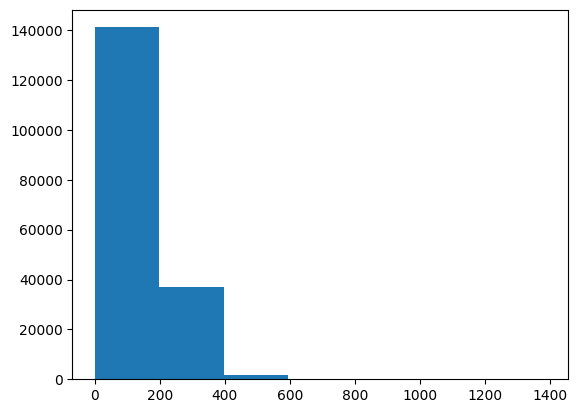

In [70]:
#check the distribution of our sequences at a characters
import matplotlib.pyplot as plt
plt.hist(char_lens, bins=7);

In [71]:
# Find what character length covers 95% of sequences
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

In [72]:
# Gell all keyboard characters
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [73]:
# create char level token vectorizer instance
NUM_CHAR_TOKENS = len(alphabet)+ 2 # add 2 for space and <OOV>(out of vocabulary)
char_vectorizer = layers.TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                           output_sequence_length=output_seq_char_len,
                                           name="char_vectorizer",
                                          standardize="lower_and_strip_punctuation") #default option


In [74]:
# adapt it into training characters
char_vectorizer.adapt(train_chars)

In [75]:
# check character vocab stats
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of differrent characters in character voacb: {len(char_vocab)}")
print(f"Most common characters:{char_vocab[:5]}")
print(f"Least common characters:{char_vocab[-5:]}")

Number of differrent characters in character voacb: 28
Most common characters:['', '[UNK]', 'e', 't', 'i']
Least common characters:['k', 'x', 'z', 'q', 'j']


In [76]:
# Test our character vectorizer
random_train_chars = random.choice(train_chars)
print(f"Charified text:\n {random_train_chars}")
print(f"Length of random_train_chars:{len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\nVectorized chars:\n{vectorized_chars}")
print(f"\nLength of vectorized chars{len(vectorized_chars[0])}")

Charified text:
 f e n t a n y l   i n j e c t i o n   o f   s m a l l   d o s e   a t   a u r i c u l a r   p o i n t s   a c h i e v e s   d e f i n i t e   a n a l g e s i c   e f f e c t   o n   p r o c e d u r a l   p a i n   i n   d r e s s i n g   c h a n g e s   o f   b u r n   w o u n d s   ,   s u p e r i o r   t o   s u b c u t a n e o u s   i n j e c t i o n   o f   f e n t a n y l   .
Length of random_train_chars:164

Vectorized chars:
[[17  2  6  3  5  6 19 12  4  6 27  2 11  3  4  7  6  7 17  9 15  5 12 12
  10  7  9  2  5  3  5 16  8  4 11 16 12  5  8 14  7  4  6  3  9  5 11 13
   4  2 21  2  9 10  2 17  4  6  4  3  2  5  6  5 12 18  2  9  4 11  2 17
  17  2 11  3  7  6 14  8  7 11  2 10 16  8  5 12 14  5  4  6  4  6 10  8
   2  9  9  4  6 18 11 13  5  6 18  2  9  7 17 22 16  8  6 20  7 16  6 10
   9  9 16 14  2  8  4  7  8  3  7  9 16 22 11 16  3  5  6  2  7 16  9  4
   6 27  2 11  3  4  7  6  7 17 17  2  6  3  5  6 19 12  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0 

### Creating a character level embedding

In [77]:
#creating a character embedding layer of 128
char_embedding = layers.Embedding(input_dim=len(char_vocab), # number of differrent characters in the vocabulary
                                  input_shape=(290,),
                                  output_dim=25, #size of the char embedding in the paper in figure.1
                                  mask_zero=True,
                                  name="char_embedding")

In [78]:
char_embedding(vectorized_chars)

<tf.Tensor: shape=(1, 290, 25), dtype=float32, numpy=
array([[[-9.1920011e-03, -4.9892008e-02,  5.8004037e-03, ...,
         -4.6531033e-02,  1.8943440e-02,  4.3375913e-02],
        [ 1.3445839e-03, -4.6540052e-05, -4.7684170e-02, ...,
          4.1606177e-02,  4.4939067e-02,  6.4174421e-03],
        [ 2.9875983e-02, -1.9343734e-02, -3.9296471e-02, ...,
          4.9600888e-02, -3.7801266e-02, -3.8824558e-02],
        ...,
        [-1.4157712e-02,  4.7549795e-02,  2.9663239e-02, ...,
         -1.1861015e-02, -1.1327792e-02, -3.2876480e-02],
        [-1.4157712e-02,  4.7549795e-02,  2.9663239e-02, ...,
         -1.1861015e-02, -1.1327792e-02, -3.2876480e-02],
        [-1.4157712e-02,  4.7549795e-02,  2.9663239e-02, ...,
         -1.1861015e-02, -1.1327792e-02, -3.2876480e-02]]], dtype=float32)>

In [79]:
# Test out character embedding layer
print(f"Charified text:\n{random_train_chars}\n")
char_embed = char_embedding(char_vectorizer([random_train_chars]))
print(f"Embedded chars after vectorization and embedding \n:{char_embed}\n")
print(f"Character embedding shape:{char_embed.shape}")

Charified text:
f e n t a n y l   i n j e c t i o n   o f   s m a l l   d o s e   a t   a u r i c u l a r   p o i n t s   a c h i e v e s   d e f i n i t e   a n a l g e s i c   e f f e c t   o n   p r o c e d u r a l   p a i n   i n   d r e s s i n g   c h a n g e s   o f   b u r n   w o u n d s   ,   s u p e r i o r   t o   s u b c u t a n e o u s   i n j e c t i o n   o f   f e n t a n y l   .

Embedded chars after vectorization and embedding 
:[[[-9.1920011e-03 -4.9892008e-02  5.8004037e-03 ... -4.6531033e-02
    1.8943440e-02  4.3375913e-02]
  [ 1.3445839e-03 -4.6540052e-05 -4.7684170e-02 ...  4.1606177e-02
    4.4939067e-02  6.4174421e-03]
  [ 2.9875983e-02 -1.9343734e-02 -3.9296471e-02 ...  4.9600888e-02
   -3.7801266e-02 -3.8824558e-02]
  ...
  [-1.4157712e-02  4.7549795e-02  2.9663239e-02 ... -1.1861015e-02
   -1.1327792e-02 -3.2876480e-02]
  [-1.4157712e-02  4.7549795e-02  2.9663239e-02 ... -1.1861015e-02
   -1.1327792e-02 -3.2876480e-02]
  [-1.4157712e-02  4.7549795e-02  2.9

In [80]:
len(random_train_chars)

383

### Building a Conv1D model to fit on character embeddings

In [81]:
#creating a model with character level embedding
inputs = layers.Input(shape=(1,), dtype="string")
#passing the inputs to char_vectorizer layer
x = char_vectorizer(inputs)
#passing the char_vector outputs to embedding layer
x = char_embedding(x)
#passing the char_embedded outputs to Conv1D layer
x = layers.Conv1D(64, kernel_size=5, activation="relu", padding="same")(x)
#creating a pooling layer for condensing the outputs of Conv1D layer
x = layers.GlobalMaxPooling1D()(x)
# # creating a dense layer as an intermediary between pooling and output layer
# x = layers.Dense(64, activation="relu")(x)
#creating the output layer
outputs = layers.Dense(5, activation="softmax")(x)
#creating the model
model_3 = tf.keras.Model(inputs, outputs, name="model_3_Conv1D_char_embedding")

#getting the model summary
model_3.summary()

Model: "model_3_Conv1D_char_embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVecto  (None, 290)               0         
 rization)                                                       
                                                                 
 char_embedding (Embedding)  (None, 290, 25)           700       
                                                                 
 conv1d_1 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_max_pooling1d (Glob  (None, 64)                0         
 alMaxPooling1D)                                                 
                                                                 
 dense_2 (Dense)             (None, 5

In [82]:
# compiling model_3
model_3.compile(loss="categorical_crossentropy",
                metrics=["accuracy"],
                optimizer="adam")


In [83]:
# create charlevel datasets
train_chars_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot))
test_chars_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot))
valid_chars_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot))

train_chars_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [84]:
#converting the dataset to prefetch batches
train_chars_dataset = train_chars_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_chars_dataset = test_chars_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_chars_dataset = valid_chars_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_chars_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [85]:
# fitting the model_3, training and validating with 10% batches
model_3_history = model_3.fit(train_chars_dataset,
                              epochs=3,
                              validation_data=valid_chars_dataset,
                              steps_per_epoch=int(0.1 * len(train_chars_dataset)),
                              validation_steps=int(0.1 * len(valid_chars_dataset)))

Epoch 1/3
562/562 [==============================] - 5s 6ms/step - loss: 1.2549 - accuracy: 0.4953 - val_loss: 1.0321 - val_accuracy: 0.5881
Epoch 2/3
562/562 [==============================] - 3s 5ms/step - loss: 1.0015 - accuracy: 0.6000 - val_loss: 0.9399 - val_accuracy: 0.6270
Epoch 3/3
562/562 [==============================] - 3s 5ms/step - loss: 0.9282 - accuracy: 0.6361 - val_loss: 0.8761 - val_accuracy: 0.6576


In [86]:
# Make predictions with character model only
model_3_pred_probs = model_3.predict(valid_chars_dataset)
model_3_pred_probs[:5]

945/945 [==============================] - 2s 3ms/step


array([[0.07387144, 0.4207875 , 0.12880221, 0.3394341 , 0.03710467],
       [0.18595457, 0.6380342 , 0.00509567, 0.15505432, 0.01586127],
       [0.08256062, 0.31618905, 0.27899617, 0.23489355, 0.08736059],
       [0.01053998, 0.02287416, 0.88154113, 0.01832039, 0.0667243 ],
       [0.01997982, 0.02515954, 0.8163708 , 0.03009084, 0.10839903]],
      dtype=float32)

In [87]:
# convert the prediction probabilities to class names
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
model_3_preds[:5]

<tf.Tensor: shape=(5,), dtype=int64, numpy=array([1, 1, 1, 2, 2])>

In [88]:
#calculate the results for conv1d model chars only
model_3_results = calculate_results(val_labels_encoded, model_3_preds)
model_3_results

{'accuracy': 65.06686084999338,
 'precision': 0.6429102857695221,
 'recall': 0.6506686084999338,
 'f1': 0.6396895669804391}

In [89]:
base_line_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Model 4: Combining pretrained token embedding  + characters embeddings(hybrid)

1. Create a token level embedding(similar to `model_1`
2. Create a character level embedding (similar to `model_3`
3. Combine 1 & 2 with a concatenate (`layers.Concatenate`)
4. Build a series of output layers on top of 3 similar to figure to Figure 1 and section 4.2
5. Construct a model which takes tokens and character-level sequences as input and produces sequence label probabilities


In [90]:
# 1. setup token inputs/model
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input")
token_embedding = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embedding)
token_model = tf.keras.Model(token_inputs, token_outputs)

#2. Setup char inputs
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embedding(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings) #bi-lstm shown in figure 1 of the paper accroding to paper is 50
char_model = tf.keras.Model(char_inputs, char_bi_lstm)               #bi directional lstm doubles the neurons

# 3. Create the concatenation layer to combine character and token embedding
token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output,
                                                                 char_model.output])

# 4. Create output layers - adding in Droupout
combined_dropout = layers.Dropout(0.5)(token_char_concat) #drops 50% of the weights of the layer to prevent over fitting
combined_dense = layers.Dense(128, activation="relu")(combined_dropout)

final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(5, activation="softmax")(final_dropout)

# 5. Construct model with char and token inputs
model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                         outputs=output_layer, name="model_4_token_and_char_embeddings")


In [91]:
# Get a summary of our model
model_4.summary()

Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_inputs (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 token_input (InputLayer)    [(None,)]                    0         []                            
                                                                                                  
 char_vectorizer (TextVecto  (None, 290)                  0         ['char_inputs[0][0]']         
 rization)                                                                                        
                                                                                                  
 universal_sentence_encoder  (None, 512)                  2567978 

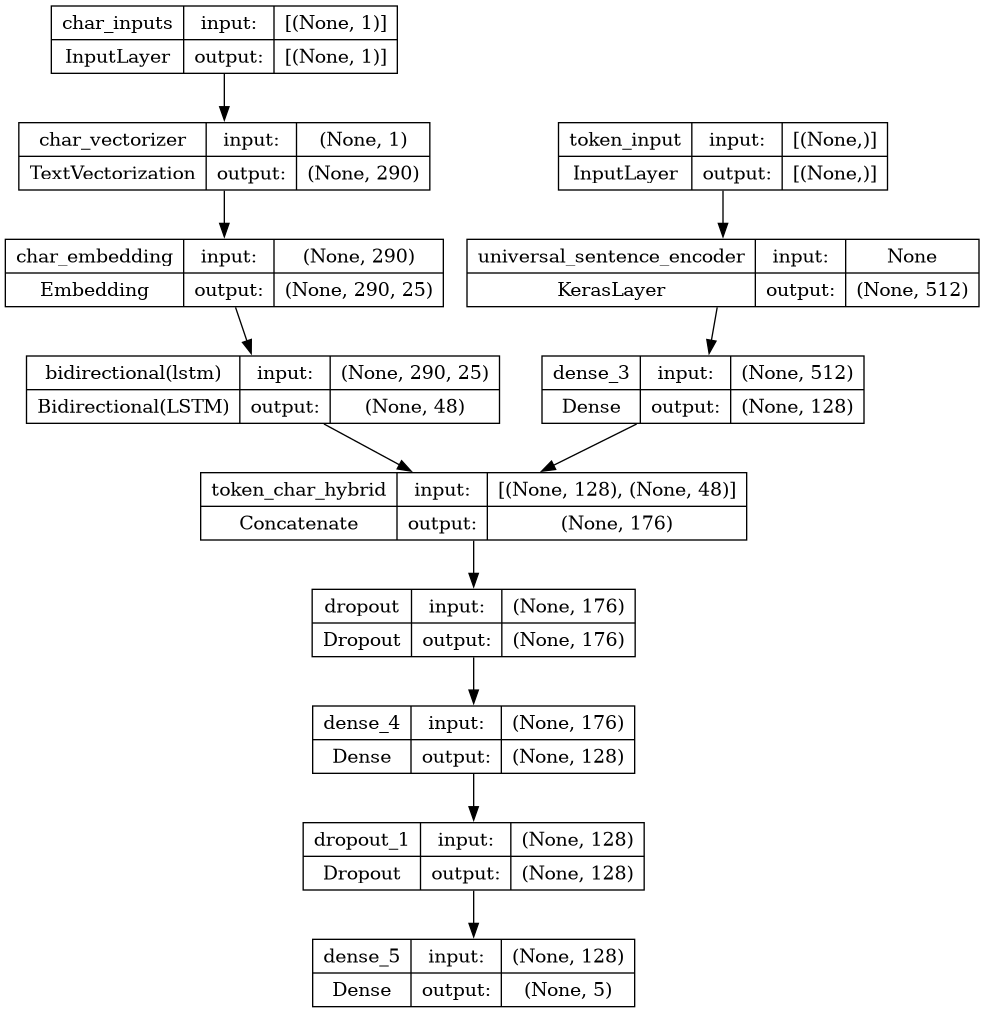

In [92]:
# Plot hybrid token and character model
from keras.utils import plot_model
plot_model(model_4, show_shapes=True)

In [93]:
# Compile token char model
model_4.compile(loss="categorical_crossentropy",
                optimizer="adam", #The paper uses SGD
                metrics=["accuracy"])

### Combining tokens and characters data into a tf.data.Dataset

In [94]:
# combining the char and token inputs into a batch for training test and validation
train_char_token_data = tf.data.Dataset.from_tensor_slices(
    (train_sentences, train_chars)) #make data
train_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) #make labels

train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_token_labels)) #combine data and labels

test_char_token_data = tf.data.Dataset.from_tensor_slices((test_sentences, test_chars))
test_token_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_char_token_dataset = tf.data.Dataset.zip((test_char_token_data, test_token_labels))

val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_token_labels))

#Prefetch and batch the data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_char_token_dataset = test_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


In [95]:
train_char_token_dataset, val_char_token_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

The order of the model inputs should be same as that of the batch

In [96]:
model_4_history = model_4.fit(train_char_token_dataset,
                              epochs=3,
                              validation_data=val_char_token_dataset,
                              steps_per_epoch=int(0.1 * len(train_char_token_dataset)),
                              validation_steps= int(0.1 * len(val_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 34s 40ms/step - loss: 0.9878 - accuracy: 0.6059 - val_loss: 0.7760 - val_accuracy: 0.6961
Epoch 2/3
562/562 [==============================] - 19s 34ms/step - loss: 0.8020 - accuracy: 0.6903 - val_loss: 0.7123 - val_accuracy: 0.7314
Epoch 3/3
562/562 [==============================] - 18s 32ms/step - loss: 0.7784 - accuracy: 0.7050 - val_loss: 0.6902 - val_accuracy: 0.7420


In [97]:
# evaluating the model on full validation dataset
model_4.evaluate(val_char_token_dataset)

945/945 [==============================] - 14s 15ms/step - loss: 0.6971 - accuracy: 0.7372


[0.6971330046653748, 0.7371905446052551]

In [98]:
# Make predictions using the token-character model hybrid
model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_pred_probs[:5]

945/945 [==============================] - 16s 14ms/step


array([[0.45749658, 0.2960916 , 0.00375007, 0.23575224, 0.00690953],
       [0.37146565, 0.40051675, 0.00202144, 0.22458032, 0.00141587],
       [0.3167133 , 0.10829546, 0.04014252, 0.5098317 , 0.02501695],
       [0.0133096 , 0.02162839, 0.81663716, 0.00798093, 0.14044395],
       [0.02780253, 0.13991997, 0.46045926, 0.01518309, 0.35663524]],
      dtype=float32)

In [99]:
# Format pred probs into pred labels
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)
model_4_preds[:5]

<tf.Tensor: shape=(5,), dtype=int64, numpy=array([0, 1, 3, 2, 2])>

In [100]:
# Calculate model 4 results
model_4_results = calculate_results(val_labels_encoded, model_4_preds)
model_4_results

{'accuracy': 73.71905203230504,
 'precision': 0.7352362426872195,
 'recall': 0.7371905203230504,
 'f1': 0.7353296121835815}

## Model 5: Transfer Learning with pretrained tokem embeddings + character embeddings + positional embedding

In [101]:
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


> **NOTE:** Any engineered features used to train a model need to be available at test time. In our case line numbers and total lines are available.

### Create Positional embeddings

In [102]:
# How many differrent line numbers are there?
train_df["line_number"].value_counts()

line_number
0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: count, dtype: int64

<Axes: ylabel='Frequency'>

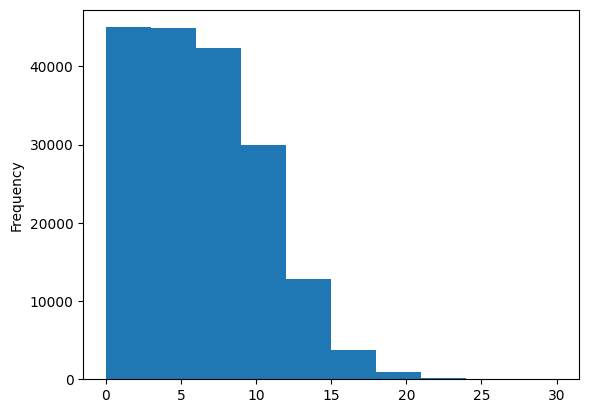

In [103]:
# check the distribution of "line_number" column
train_df.line_number.plot.hist()

In [104]:
#checking the percentile value which represents most of the line numbers
np.percentile(train_df.line_number.to_numpy(), 98)

15.0

In [105]:
# Use tensorflow to create onehot encoded line number tensors
train_line_numbers_one_hot = tf.one_hot(train_df.line_number.to_numpy(), depth=15)
train_line_numbers_one_hot[:10], train_line_numbers_one_hot.shape

(<tf.Tensor: shape=(10, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]],
       dtype=float32)>,
 TensorShape([180040, 15]))

In [106]:
#doing the same for validation and test data
val_line_numbers_one_hot = tf.one_hot(val_df.line_number.to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df.line_number.to_numpy(), depth=15)

Now we have encoded our line numbers feature, let's do the same for total lines

In [107]:
train_df["total_lines"].value_counts()

total_lines
11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: count, dtype: int64

In [108]:
#checking the most suitable value for depth of one-hot encoded labels
np.percentile(train_df.total_lines.to_numpy(), 98)

20.0

<Axes: ylabel='Frequency'>

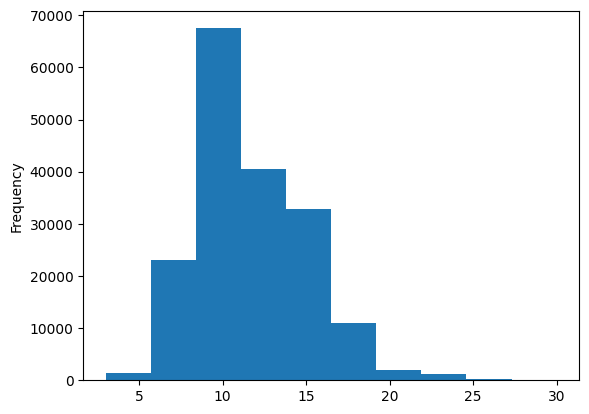

In [109]:
# Check the distribution of the data
train_df.total_lines.plot(kind="hist")

In [110]:
# Use Tensorflow to create one hot encoded tensors of our total_lines
train_total_lines_one_hot = tf.one_hot(train_df.total_lines.to_numpy(), depth=20)
train_total_lines_one_hot[:10], train_total_lines_one_hot.shape

(<tf.Tensor: shape=(10, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0

In [111]:
#doing the same operation on validation and test data
val_total_lines_one_hot = tf.one_hot(val_df.total_lines.to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df.total_lines.to_numpy(), depth=20)

### Building a tribrid model

1. Create a token-level model
2. Create a character-level model
3. Create a model for the "line_number" feature
4. Create a model for the "total_line" feature
5. Combine the outputs of 1 and 2 using tf.keras.layers.Concatenate
6. Combine the outputs of 3,4,5 using tf.keras.layers.Concatenate
7. Create an output layer to accept the concatenated embeddings and predict the output label probabilities
8. Combine the inputs of 1,2,3,4 and outputs of into a tf.keras.Model

In [112]:
# 1. Token inputs
token_inputs = layers.Input(shape=[], dtype="string", name="token_embedding")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs, outputs = token_outputs)

#2. Char inputs
char_inputs = layers.Input(shape=(1,), dtype="string", name="char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embedding(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(inputs = char_inputs,
                            outputs = char_bi_lstm)

#3. Create a model for line number feature
line_number_inputs = layers.Input(shape=[15,], name="line_number_input", dtype=tf.float32)
line_number_outputs = layers.Dense(32, activation="relu")(line_number_inputs)
line_number_model = tf.keras.Model(line_number_inputs, line_number_outputs)

#4. Create a model for total line feature
total_line_inputs = layers.Input(shape=[20,], name="total_lines_input", dtype=tf.float32)
total_line_outputs = layers.Dense(32, activation="relu")(total_line_inputs)
total_lines_model = tf.keras.Model(total_line_inputs, total_line_outputs)


#5. Combine token and char embeddings into a hybrid embedding
combined_embeddings = layers.Concatenate(name="char_token_hybrid_embedding")([token_model.output,
                                                                              char_model.output])

#5.5 Create a dropout layer to drop 50% weights
intermediate_dense_layer = layers.Dense(256, activation="relu")(combined_embeddings)
intermediate_dropout_layer = layers.Dropout(0.5)(intermediate_dense_layer)


#6. Combine the positional embeddings with combined token and char embeddings
tribrid_embeddings = layers.Concatenate(name="char_token_positional_embedding")([
    line_number_model.output,
    total_lines_model.output,
    intermediate_dropout_layer
])


#7. Create output layer
output_layer = layers.Dense(5, activation="softmax", name="output_layer")(tribrid_embeddings)

#8. Put together model with all inputs
model_5 = tf.keras.Model(inputs=[
    line_number_model.input,
    total_lines_model.input,
    token_model.input,
    char_model.input
],
                         outputs=output_layer, name="model_5_tribrid_embedding")

> **NOTE:** Dropout layer has no output

In [113]:
# Get the summary of the tribrid embedding model
model_5.summary()

Model: "model_5_tribrid_embedding"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_inputs (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 token_embedding (InputLaye  [(None,)]                    0         []                            
 r)                                                                                               
                                                                                                  
 char_vectorizer (TextVecto  (None, 290)                  0         ['char_inputs[0][0]']         
 rization)                                                                                        
                                                                          

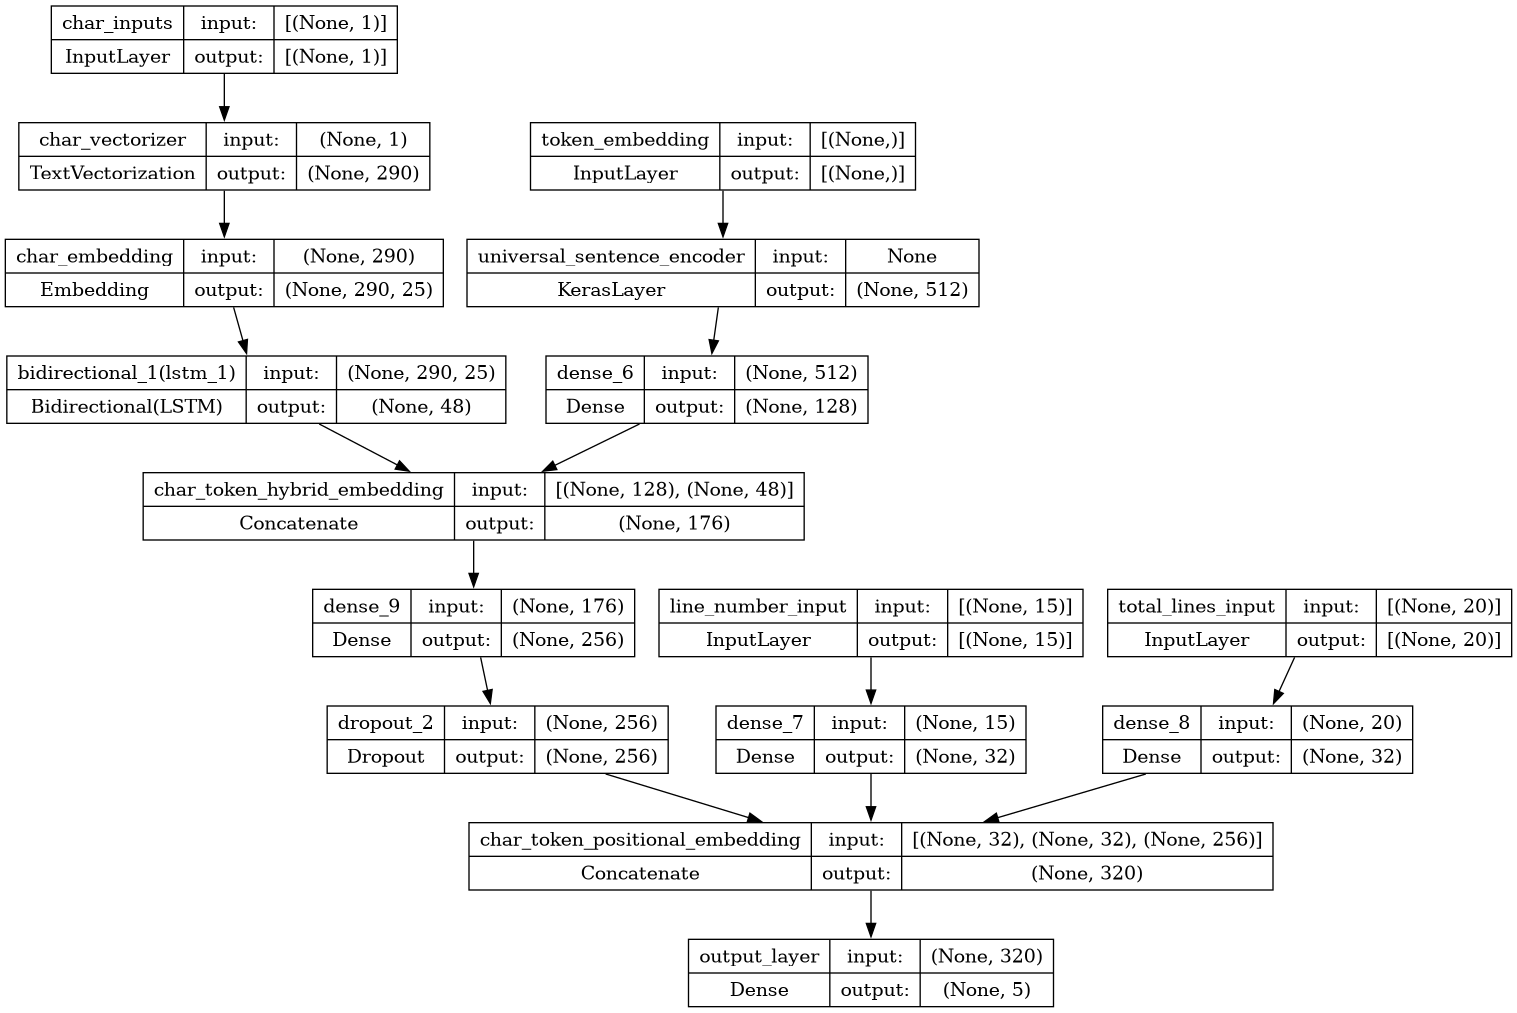

In [114]:
#Plotting the model architecture
from keras.utils import plot_model
plot_model(model_5, show_shapes=True)

**Label Smoothing**

If our model gets too confident on a single class i.e, the prediction probability is too high, it may stop learning altogether and stick to that particular class by completely ignoring other classes. What label smoothing does is that it will assign the prediction probabilities of the highest class to other classes. In turn hopefully improving the generalization ability of the model.

In [115]:
#compiling the model_5
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), #helps you to prevent overfitting
                optimizer = tf.keras.optimizers.legacy.Adam(),
                metrics=["accuracy"])

### Create tribrid embedding datasets using tf.data

In [116]:
#creating training and validation data with all four kinds of data
train_char_token_pos_data = tf.data.Dataset.from_tensor_slices((
    train_line_numbers_one_hot,
    train_total_lines_one_hot,
    train_sentences,
    train_chars
))

train_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)

train_char_token_pos_dataset = tf.data.Dataset.zip((train_char_token_pos_data, train_char_token_pos_labels))
train_char_token_pos_dataset = train_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)



val_char_token_pos_data = tf.data.Dataset.from_tensor_slices((
    val_line_numbers_one_hot,
    val_total_lines_one_hot,
    val_sentences,
    val_chars
))

val_char_token_pos_data = tf.data.Dataset.from_tensor_slices((
    val_line_numbers_one_hot,
    val_total_lines_one_hot,
    val_sentences,
    val_chars
))

val_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)

val_char_token_pos_dataset = tf.data.Dataset.zip((val_char_token_pos_data, val_char_token_pos_labels))
val_char_token_pos_dataset = val_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)



In [117]:
#check the input shapes
train_char_token_pos_dataset ,  val_char_token_pos_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

### Fitting and evaluating the model


In [118]:
history_model_5 = model_5.fit(train_char_token_pos_dataset,
                              epochs=3,
                              validation_data=val_char_token_pos_dataset,
                              steps_per_epoch=int(0.1 * len(train_char_token_pos_dataset)),
                              validation_steps=int(0.1 * len(val_char_token_pos_dataset))
                             )


Epoch 1/3
562/562 [==============================] - 31s 39ms/step - loss: 1.0924 - accuracy: 0.7262 - val_loss: 0.9810 - val_accuracy: 0.8062
Epoch 2/3
562/562 [==============================] - 19s 34ms/step - loss: 0.9639 - accuracy: 0.8171 - val_loss: 0.9494 - val_accuracy: 0.8275
Epoch 3/3
562/562 [==============================] - 17s 31ms/step - loss: 0.9467 - accuracy: 0.8253 - val_loss: 0.9380 - val_accuracy: 0.8338


In [119]:
#evaluating the model of the full validation dataset
model_5_pred_probs = model_5.predict(val_char_token_pos_dataset)
model_5_pred_probs[:5]

945/945 [==============================] - 16s 14ms/step


array([[0.5050514 , 0.10652892, 0.01116911, 0.3589658 , 0.01828482],
       [0.51116496, 0.11355164, 0.03262696, 0.33211058, 0.01054588],
       [0.26599985, 0.0954843 , 0.11865852, 0.4540174 , 0.06583998],
       [0.03918282, 0.06530758, 0.6763132 , 0.04050663, 0.17868978],
       [0.06131193, 0.05197313, 0.6386547 , 0.0562961 , 0.19176409]],
      dtype=float32)

In [120]:
#converting the prediction probabilities to prediction labels
model_5_preds = tf.argmax(model_5_pred_probs, axis=1)
model_5_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [121]:
#calculating the model_5 results
model_5_results = calculate_results(val_labels_encoded, model_5_preds)
model_5_results

{'accuracy': 83.5032437442076,
 'precision': 0.8341751793373661,
 'recall': 0.835032437442076,
 'f1': 0.8341445336796388}

In [122]:
model_4_results

{'accuracy': 73.71905203230504,
 'precision': 0.7352362426872195,
 'recall': 0.7371905203230504,
 'f1': 0.7353296121835815}

In [123]:
base_line_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

We can see a significant improvement in the results compared to the baseline model we created as well as the `model_4`.

## Model 6: Replicating `model_5` and training on full dataset

Our model 5 is the best performing model so far. Let's fit it on the complete train data and check the results.

In [124]:
# 1. Token inputs
token_inputs = layers.Input(shape=[], dtype="string", name="token_embedding")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs, outputs = token_outputs)

#2. Char inputs
char_inputs = layers.Input(shape=(1,), dtype="string", name="char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embedding(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(inputs = char_inputs,
                            outputs = char_bi_lstm)

#3. Create a model for line number feature
line_number_inputs = layers.Input(shape=[15,], name="line_number_input", dtype=tf.float32)
line_number_outputs = layers.Dense(32, activation="relu")(line_number_inputs)
line_number_model = tf.keras.Model(line_number_inputs, line_number_outputs)

#4. Create a model for total line feature
total_line_inputs = layers.Input(shape=[20,], name="total_lines_input", dtype=tf.float32)
total_line_outputs = layers.Dense(32, activation="relu")(total_line_inputs)
total_lines_model = tf.keras.Model(total_line_inputs, total_line_outputs)


#5. Combine token and char embeddings into a hybrid embedding
combined_embeddings = layers.Concatenate(name="char_token_hybrid_embedding")([token_model.output,
                                                                              char_model.output])

#5.5 Create a dropout layer to drop 50% weights
intermediate_dense_layer = layers.Dense(256, activation="relu")(combined_embeddings)
intermediate_dropout_layer = layers.Dropout(0.5)(intermediate_dense_layer)


#6. Combine the positional embeddings with combined token and char embeddings
tribrid_embeddings = layers.Concatenate(name="char_token_positional_embedding")([
    line_number_model.output,
    total_lines_model.output,
    intermediate_dropout_layer
])


#7. Create output layer
output_layer = layers.Dense(5, activation="softmax", name="output_layer")(tribrid_embeddings)

#8. Put together model with all inputs
model_6 = tf.keras.Model(inputs=[
    line_number_model.input,
    total_lines_model.input,
    token_model.input,
    char_model.input
],
                         outputs=output_layer, name="model_6_tribrid_embedding")

In [125]:
#getting the model summary
model_6.summary()

Model: "model_6_tribrid_embedding"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_inputs (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 token_embedding (InputLaye  [(None,)]                    0         []                            
 r)                                                                                               
                                                                                                  
 char_vectorizer (TextVecto  (None, 290)                  0         ['char_inputs[0][0]']         
 rization)                                                                                        
                                                                          

In [126]:
#compiling the cloned_model_5
model_6.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), #helps you to prevent overfitting
                optimizer = tf.keras.optimizers.legacy.Adam(),
                metrics=["accuracy"])

In [127]:
#training on full train dataset and validating on 10% of validation dataset for 5 epochs
history_model_6 = model_6.fit(train_char_token_pos_dataset,
                              epochs=5,
                              validation_data=val_char_token_pos_dataset,
                              validation_steps=int(0.1 * len(val_char_token_pos_dataset))
                             )

Epoch 1/5
5627/5627 [==============================] - 194s 33ms/step - loss: 0.9531 - accuracy: 0.8231 - val_loss: 0.9131 - val_accuracy: 0.8424
Epoch 2/5
5627/5627 [==============================] - 183s 33ms/step - loss: 0.9083 - accuracy: 0.8546 - val_loss: 0.9062 - val_accuracy: 0.8431
Epoch 3/5
5627/5627 [==============================] - 183s 32ms/step - loss: 0.8955 - accuracy: 0.8642 - val_loss: 0.9018 - val_accuracy: 0.8504
Epoch 4/5
5627/5627 [==============================] - 182s 32ms/step - loss: 0.8868 - accuracy: 0.8705 - val_loss: 0.9023 - val_accuracy: 0.8534
Epoch 5/5
5627/5627 [==============================] - 182s 32ms/step - loss: 0.8799 - accuracy: 0.8754 - val_loss: 0.9025 - val_accuracy: 0.8531


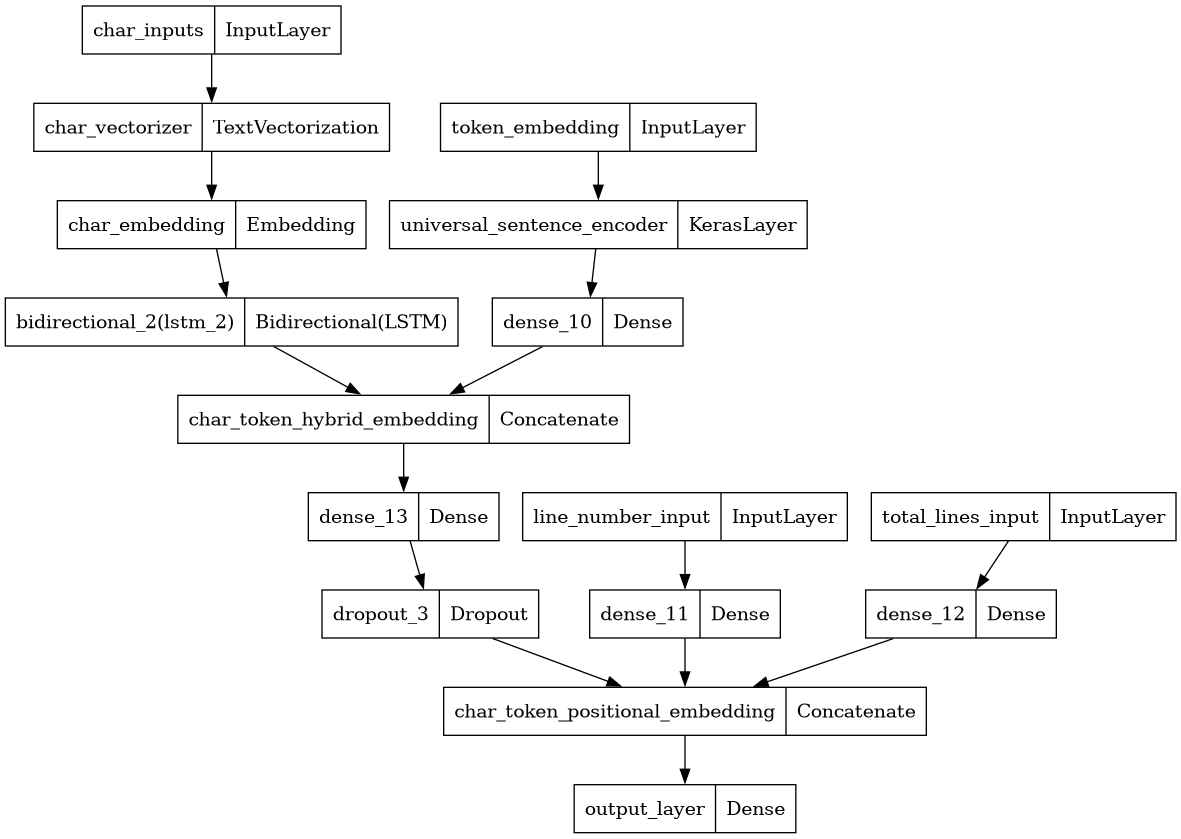

In [128]:
#visualising the model architecture
from keras.utils import plot_model
plot_model(model_6)

In [129]:
#evaluating the model on complete validation data
model_6_pred_probs = model_6.predict(val_char_token_pos_dataset)
model_6_preds = tf.argmax(model_6_pred_probs, axis=1)
model_6_preds

945/945 [==============================] - 16s 14ms/step


<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [130]:
#evaluating the model on the complete validation dataset
model_6_results = calculate_results(val_labels_encoded, model_6_preds)
model_6_results

{'accuracy': 85.74076525883754,
 'precision': 0.8589809950936701,
 'recall': 0.8574076525883755,
 'f1': 0.8549082570560692}

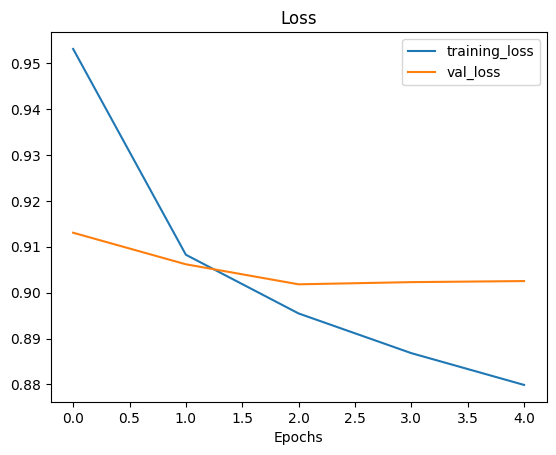

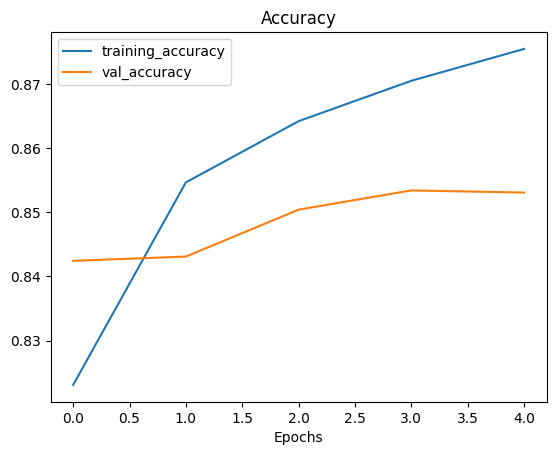

In [131]:
#plotting the loss curves of model_6
from helper_functions import plot_loss_curves
plot_loss_curves(history_model_6)

In [132]:
#calculate m

In [133]:
#evaluating our model on full test data.
test_char_token_pos_data = tf.data.Dataset.from_tensor_slices((
    test_line_numbers_one_hot,
    test_total_lines_one_hot,
    test_sentences,
    test_chars
))

test_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)

test_char_token_pos_dataset = tf.data.Dataset.zip((test_char_token_pos_data, test_char_token_pos_labels))
test_char_token_pos_dataset = test_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [134]:
test_results = model_6.predict(test_char_token_pos_dataset)
test_preds = tf.argmax(test_results, axis=1)
model_6_result = calculate_results(test_labels_encoded, test_preds)
model_6_result

942/942 [==============================] - 14s 15ms/step


{'accuracy': 85.04728720756596,
 'precision': 0.8505570198947183,
 'recall': 0.8504728720756596,
 'f1': 0.8477141560891309}

## Model 7: Replicating model 6 with cnn

In [135]:
# creating an embedding instance
token_embedding = layers.Embedding(
    input_dim=len(rct_20_k_text_vocab),
    input_shape=(int(output_seq_length),),#NOTE: differrent embedding sizes gives drastically differrent results
    output_dim=128,
    mask_zero=True,#use masking to handle variable sequence langths(save space)
    name="token_embedding",
)

In [136]:
# Creating a model similar to model_1 with positional embedding and character emebeddings
# 1. Token inputs
token_inputs = layers.Input(shape=(1,), dtype=tf.string, name="token_embedding_input")
text_vectorized_inputs = text_vectorizer(token_inputs)
# print(text_vectorized_inputs.shape)
token_embeddings = token_embedding(text_vectorized_inputs)
# print(token_embeddings.shape)
conv1_output = layers.Conv1D(128,5, activation="relu")(token_embeddings)
conv2_output = layers.Conv1D(128,5, activation="relu")(conv1_output)
pool_output = layers.GlobalMaxPool1D()(conv2_output)
token_outputs = layers.Dense(128, activation="relu")(pool_output)
token_model = tf.keras.Model(inputs=token_inputs, outputs = token_outputs)

#2. Char inputs
char_inputs = layers.Input(shape=(1,), dtype="string", name="char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embedding(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(inputs = char_inputs,
                            outputs = char_bi_lstm)

#3. Create a model for line number feature
line_number_inputs = layers.Input(shape=[15,], name="line_number_input", dtype=tf.float32)
line_number_outputs = layers.Dense(32, activation="relu")(line_number_inputs)
line_number_model = tf.keras.Model(line_number_inputs, line_number_outputs)

#4. Create a model for total line feature
total_line_inputs = layers.Input(shape=[20,], name="total_lines_input", dtype=tf.float32)
total_line_outputs = layers.Dense(32, activation="relu")(total_line_inputs)
total_lines_model = tf.keras.Model(total_line_inputs, total_line_outputs)


#5. Combine token and char embeddings into a hybrid embedding
combined_embeddings = layers.Concatenate(name="char_token_hybrid_embedding")([token_model.output,
                                                                              char_model.output])

#5.5 Create a dropout layer to drop 50% weights
intermediate_dense_layer = layers.Dense(256, activation="relu")(combined_embeddings)
intermediate_dropout_layer = layers.Dropout(0.5)(intermediate_dense_layer)


#6. Combine the positional embeddings with combined token and char embeddings
tribrid_embeddings = layers.Concatenate(name="char_token_positional_embedding")([
    line_number_model.output,
    total_lines_model.output,
    intermediate_dropout_layer
])


#7. Create output layer
output_layer = layers.Dense(5, activation="softmax", name="output_layer")(tribrid_embeddings)

#8. Put together model with all inputs
model_7 = tf.keras.Model(inputs=[
    line_number_model.input,
    total_lines_model.input,
    token_model.input,
    char_model.input
],
                         outputs=output_layer, name="model_7_tribrid_embedding_with_cnn")

In [137]:
#compiling the model_7
model_7.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), #helps you to prevent overfitting
                optimizer = tf.keras.optimizers.legacy.Adam(),
                metrics=["accuracy"])

In [138]:
#fitting the model_7 for 3 epochs and training and validating for 10% of the batch sizes
history_model_7 = model_7.fit(train_char_token_pos_dataset,
                             epochs=3,
                             validation_data=val_char_token_pos_dataset,
                             validation_steps = int(0.1 * len(val_char_token_pos_dataset)),
                             steps_per_epoch=int(0.1 * len(train_char_token_pos_dataset)))

Epoch 1/3
562/562 [==============================] - 30s 38ms/step - loss: 1.0928 - accuracy: 0.7235 - val_loss: 0.9303 - val_accuracy: 0.8381
Epoch 2/3
562/562 [==============================] - 19s 34ms/step - loss: 0.9366 - accuracy: 0.8360 - val_loss: 0.9164 - val_accuracy: 0.8447
Epoch 3/3
562/562 [==============================] - 17s 30ms/step - loss: 0.9194 - accuracy: 0.8449 - val_loss: 0.9045 - val_accuracy: 0.8471


In [139]:
#evaluating the model on complete validation data
model_7_pred_probs = model_7.predict(val_char_token_pos_dataset)
model_7_preds = tf.argmax(model_7_pred_probs, axis=1)
model_7_results = calculate_results(val_labels_encoded, model_7_preds)

945/945 [==============================] - 13s 11ms/step


In [140]:
model_7_results

{'accuracy': 85.191314709387,
 'precision': 0.8508665568546536,
 'recall': 0.85191314709387,
 'f1': 0.8503994591157719}

## Model 8 : Replicating model_6 with LSTM 

In [141]:
# Creating a model similar to model_7 with LSTM
# 1. Token inputs
token_inputs = layers.Input(shape=(1,), dtype=tf.string, name="token_embedding_input")
text_vectorized_inputs = text_vectorizer(token_inputs)
# print(text_vectorized_inputs.shape)
token_embeddings = token_embedding(text_vectorized_inputs)
# print(token_embeddings.shape)
lstm1_output = layers.LSTM(256, return_sequences=True, activation="relu")(token_embeddings)
lstm2_output = layers.LSTM(256, activation="relu")(lstm1_output)

token_outputs = layers.Dense(128, activation="relu")(lstm2_output)
token_model = tf.keras.Model(inputs=token_inputs, outputs = token_outputs)

#2. Char inputs
char_inputs = layers.Input(shape=(1,), dtype="string", name="char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embedding(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(inputs = char_inputs,
                            outputs = char_bi_lstm)

#3. Create a model for line number feature
line_number_inputs = layers.Input(shape=[15,], name="line_number_input", dtype=tf.float32)
line_number_outputs = layers.Dense(32, activation="relu")(line_number_inputs)
line_number_model = tf.keras.Model(line_number_inputs, line_number_outputs)

#4. Create a model for total line feature
total_line_inputs = layers.Input(shape=[20,], name="total_lines_input", dtype=tf.float32)
total_line_outputs = layers.Dense(32, activation="relu")(total_line_inputs)
total_lines_model = tf.keras.Model(total_line_inputs, total_line_outputs)


#5. Combine token and char embeddings into a hybrid embedding
combined_embeddings = layers.Concatenate(name="char_token_hybrid_embedding")([token_model.output,
                                                                              char_model.output])

#5.5 Create a dropout layer to drop 50% weights
intermediate_dense_layer = layers.Dense(256, activation="relu")(combined_embeddings)
intermediate_dropout_layer = layers.Dropout(0.5)(intermediate_dense_layer)


#6. Combine the positional embeddings with combined token and char embeddings
tribrid_embeddings = layers.Concatenate(name="char_token_positional_embedding")([
    line_number_model.output,
    total_lines_model.output,
    intermediate_dropout_layer
])


#7. Create output layer
output_layer = layers.Dense(5, activation="softmax", name="output_layer")(tribrid_embeddings)

#8. Put together model with all inputs
model_8 = tf.keras.Model(inputs=[
    line_number_model.input,
    total_lines_model.input,
    token_model.input,
    char_model.input
],
                         outputs=output_layer, name="model_8_tribrid_embedding_with_LSTM")

In [142]:
#compiling model_8
model_8.compile(loss="categorical_crossentropy",
                               metrics=["accuracy"],
               optimizer=tf.keras.optimizers.Adam())


In [143]:
#fitting the model for 3 epochs and 10% data
history_model_8 = model_8.fit(train_char_token_pos_dataset,
                             epochs=3,
                             validation_data=val_char_token_pos_dataset,
                             validation_steps = int(0.1 * len(val_char_token_pos_dataset)),
                             steps_per_epoch=int(0.1 * len(train_char_token_pos_dataset)))

Epoch 1/3
562/562 [==============================] - 169s 276ms/step - loss: 1.0320 - accuracy: 0.6768 - val_loss: 0.5687 - val_accuracy: 0.8015
Epoch 2/3
562/562 [==============================] - 141s 251ms/step - loss: 1.7640 - accuracy: 0.7811 - val_loss: 0.4768 - val_accuracy: 0.8128
Epoch 3/3
562/562 [==============================] - 139s 247ms/step - loss: 0.5312 - accuracy: 0.8270 - val_loss: 0.4585 - val_accuracy: 0.8238


In [144]:
#evaluating the model on complete validation data
model_8_pred_probs = model_8.predict(val_char_token_pos_dataset)
model_8_preds = tf.argmax(model_8_pred_probs, axis=1)
model_8_results = calculate_results(val_labels_encoded, model_8_preds)

945/945 [==============================] - 31s 30ms/step


In [145]:
model_8_results

{'accuracy': 82.3414537269959,
 'precision': 0.8246286049746034,
 'recall': 0.823414537269959,
 'f1': 0.8232828615776905}

## Compare our model results

In [146]:
#combine model resuts into a dataframe
all_model_results = pd.DataFrame({"model_0_baseline":base_line_results,
                                  "model_1_custom_token_embedding":model_1_results,
                                  "model_2_pretrained_token_embedding":model_2_results,
                                  "model_3_custom_char_embedding":model_3_results,
                                  "model_4_hybrid_char_token_embedding":model_4_results,
                                  "model_5_pos_char_token_embedding":model_5_results,
                                  "model_6_pos_char_token_embedding_full_data":model_6_results,
                                 "model_7_pos_char_token_embedding_cnn":model_7_results,
                                 "model_8_pos_char_token_embedding_LSTM":model_8_results}).T

all_model_results

,accuracy,precision,recall,f1
model_0_baseline,72.183238,0.718647,0.721832,0.698925
model_1_custom_token_embedding,78.726996,0.784009,0.787270,0.784838
model_2_pretrained_token_embedding,71.385542,0.715584,0.713855,0.710774
model_3_custom_char_embedding,65.066861,0.642910,0.650669,0.639690
model_4_hybrid_char_token_embedding,73.719052,0.735236,0.737191,0.735330
model_5_pos_char_token_embedding,83.503244,0.834175,0.835032,0.834145
model_6_pos_char_token_embedding_full_data,85.740765,0.858981,0.857408,0.854908
model_7_pos_char_token_embedding_cnn,85.191315,0.850867,0.851913,0.850399
model_8_pos_char_token_embedding_LSTM,82.341454,0.824629,0.823415,0.823283


In [147]:
# Reduce the accuracy to same scale as other metrics
all_model_results["accuracy"] = all_model_results.accuracy / 100

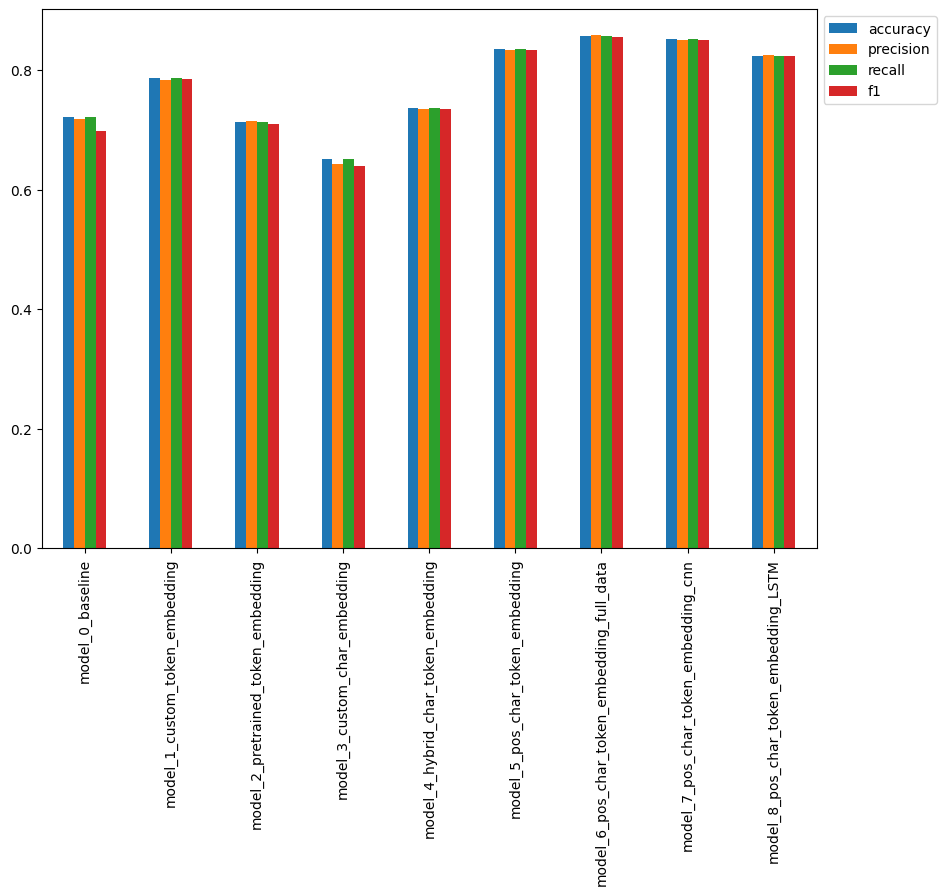

In [148]:
# Plot and compare all model results
all_model_results.plot(kind="bar", figsize=(10,7)).legend(bbox_to_anchor=(1.0,1.0))

<Axes: >

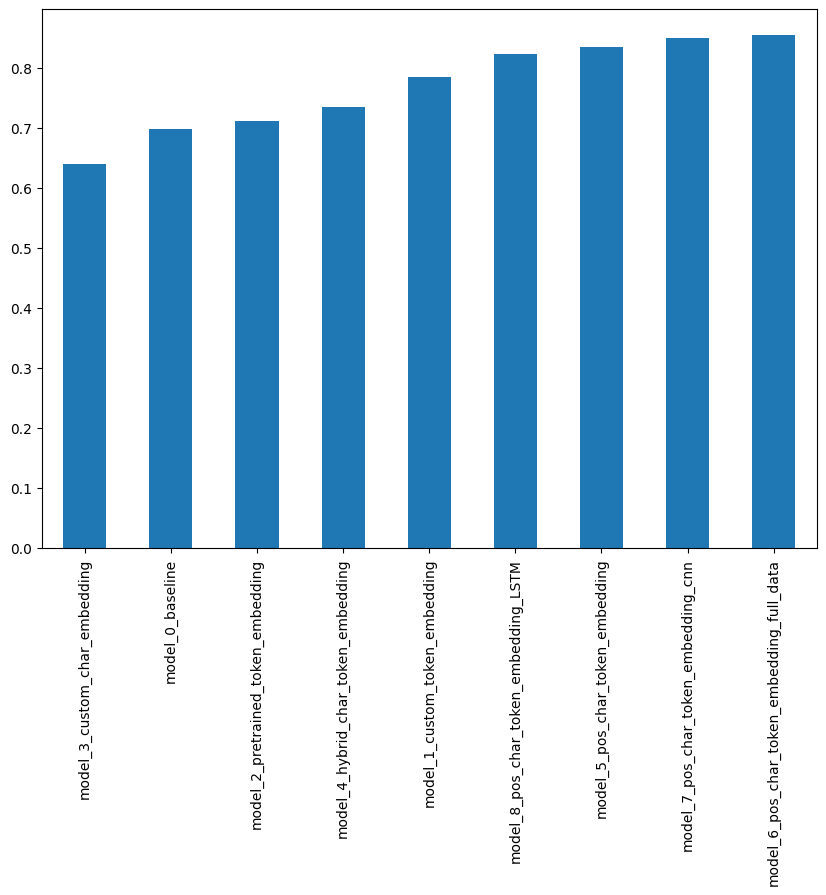

In [149]:
# Sort the model's results to score the models by f1-scores
all_model_results.sort_values("f1", ascending=True)["f1"].plot(kind="bar", figsize=(10,7))

## Model:9 Improving our CNN model

We have seen that the CNN model performs reasonably better compared to other models. It even came close to our transfer learning. Let's improve the model by increasing the number of layers.

In [150]:
# creating an embedding instance
token_embedding = layers.Embedding(
    input_dim=len(rct_20_k_text_vocab),
    input_shape=(int(output_seq_length),),#NOTE: differrent embedding sizes gives drastically differrent results
    output_dim=128,
    mask_zero=True,#use masking to handle variable sequence langths(save space)
    name="token_embedding",
)

In [151]:
# Creating a model similar to model_1 with positional embedding and character emebeddings
# 1. Token inputs
token_inputs = layers.Input(shape=(1,), dtype=tf.string, name="token_embedding_input")
text_vectorized_inputs = text_vectorizer(token_inputs)
# print(text_vectorized_inputs.shape)
token_embeddings = token_embedding(text_vectorized_inputs)
# print(token_embeddings.shape)
conv1_output = layers.Conv1D(128,5, activation="relu")(token_embeddings)
conv2_output = layers.Conv1D(128,5, activation="relu")(conv1_output)
conv3_output = layers.Conv1D(128,5, activation="relu")(conv2_output)
pool_output = layers.GlobalMaxPool1D()(conv3_output)
token_outputs = layers.Dense(128, activation="relu")(pool_output)
token_model = tf.keras.Model(inputs=token_inputs, outputs = token_outputs)

#2. Char inputs
char_inputs = layers.Input(shape=(1,), dtype="string", name="char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embedding(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(inputs = char_inputs,
                            outputs = char_bi_lstm)

#3. Create a model for line number feature
line_number_inputs = layers.Input(shape=[15,], name="line_number_input", dtype=tf.float32)
line_number_outputs = layers.Dense(32, activation="relu")(line_number_inputs)
line_number_model = tf.keras.Model(line_number_inputs, line_number_outputs)

#4. Create a model for total line feature
total_line_inputs = layers.Input(shape=[20,], name="total_lines_input", dtype=tf.float32)
total_line_outputs = layers.Dense(32, activation="relu")(total_line_inputs)
total_lines_model = tf.keras.Model(total_line_inputs, total_line_outputs)


#5. Combine token and char embeddings into a hybrid embedding
combined_embeddings = layers.Concatenate(name="char_token_hybrid_embedding")([token_model.output,
                                                                              char_model.output])

#5.5 Create a dropout layer to drop 50% weights
intermediate_dense_layer = layers.Dense(256, activation="relu")(combined_embeddings)
intermediate_dropout_layer = layers.Dropout(0.5)(intermediate_dense_layer)


#6. Combine the positional embeddings with combined token and char embeddings
tribrid_embeddings = layers.Concatenate(name="char_token_positional_embedding")([
    line_number_model.output,
    total_lines_model.output,
    intermediate_dropout_layer
])


#7. Create output layer
output_layer = layers.Dense(5, activation="softmax", name="output_layer")(tribrid_embeddings)

#8. Put together model with all inputs
model_9 = tf.keras.Model(inputs=[
    line_number_model.input,
    total_lines_model.input,
    token_model.input,
    char_model.input
],
                         outputs=output_layer, name="model_9_tribrid_embedding_with_improved_cnn")

In [152]:
#compiling the model_9
model_9.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
               optimizer="adam",
               metrics=["accuracy"])

In [153]:
#fitting the model on full train data 
history_model_9 = model_9.fit(train_char_token_pos_dataset,
                             epochs=3,
                             validation_data=val_char_token_pos_dataset,
                             validation_steps = int(0.1 * len(val_char_token_pos_dataset)))

Epoch 1/3
5627/5627 [==============================] - 223s 38ms/step - loss: 0.9352 - accuracy: 0.8341 - val_loss: 0.8862 - val_accuracy: 0.8600
Epoch 2/3
5627/5627 [==============================] - 189s 34ms/step - loss: 0.8642 - accuracy: 0.8814 - val_loss: 0.8920 - val_accuracy: 0.8537
Epoch 3/3
5627/5627 [==============================] - 191s 34ms/step - loss: 0.8322 - accuracy: 0.9032 - val_loss: 0.8917 - val_accuracy: 0.8551


In [154]:
#making predictions on the full validation data
model_9_pred_probs = model_9.predict(val_char_token_pos_dataset)
model_9_preds = tf.argmax(model_9_pred_probs, axis=1)
model_9_results = calculate_results(val_labels_encoded, model_9_preds)
model_9_results

945/945 [==============================] - 13s 11ms/step


{'accuracy': 85.06553687276579,
 'precision': 0.8502098360199238,
 'recall': 0.8506553687276579,
 'f1': 0.8485832781156053}

In [155]:
model_9_results["accuracy"] = model_9_results["accuracy"]/100.0
model_9_results

{'accuracy': 0.8506553687276579,
 'precision': 0.8502098360199238,
 'recall': 0.8506553687276579,
 'f1': 0.8485832781156053}

In [156]:
all_model_results = all_model_results.T
all_model_results

,model_0_baseline,model_1_custom_token_embedding,model_2_pretrained_token_embedding,model_3_custom_char_embedding,model_4_hybrid_char_token_embedding,model_5_pos_char_token_embedding,model_6_pos_char_token_embedding_full_data,model_7_pos_char_token_embedding_cnn,model_8_pos_char_token_embedding_LSTM
accuracy,0.721832,0.787270,0.713855,0.650669,0.737191,0.835032,0.857408,0.851913,0.823415
precision,0.718647,0.784009,0.715584,0.642910,0.735236,0.834175,0.858981,0.850867,0.824629
recall,0.721832,0.787270,0.713855,0.650669,0.737191,0.835032,0.857408,0.851913,0.823415
f1,0.698925,0.784838,0.710774,0.639690,0.735330,0.834145,0.854908,0.850399,0.823283


In [157]:
all_model_results["model_9_improved_cnn"] = model_9_results
all_model_results

,model_0_baseline,model_1_custom_token_embedding,model_2_pretrained_token_embedding,model_3_custom_char_embedding,model_4_hybrid_char_token_embedding,model_5_pos_char_token_embedding,model_6_pos_char_token_embedding_full_data,model_7_pos_char_token_embedding_cnn,model_8_pos_char_token_embedding_LSTM,model_9_improved_cnn
accuracy,0.721832,0.787270,0.713855,0.650669,0.737191,0.835032,0.857408,0.851913,0.823415,0.850655
precision,0.718647,0.784009,0.715584,0.642910,0.735236,0.834175,0.858981,0.850867,0.824629,0.850210
recall,0.721832,0.787270,0.713855,0.650669,0.737191,0.835032,0.857408,0.851913,0.823415,0.850655
f1,0.698925,0.784838,0.710774,0.639690,0.735330,0.834145,0.854908,0.850399,0.823283,0.848583


In [158]:
all_model_results = all_model_results.T

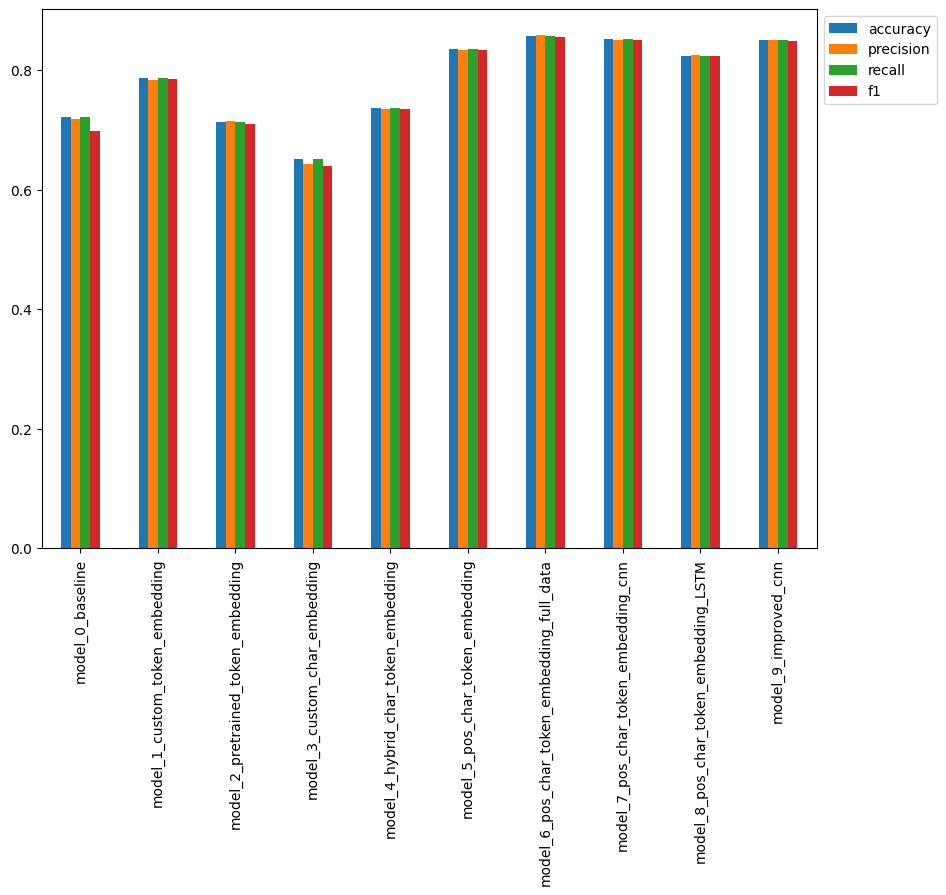

In [159]:
# Plot and compare all model results
all_model_results.plot(kind="bar", figsize=(10,7)).legend(bbox_to_anchor=(1.0,1.0))

<Axes: >

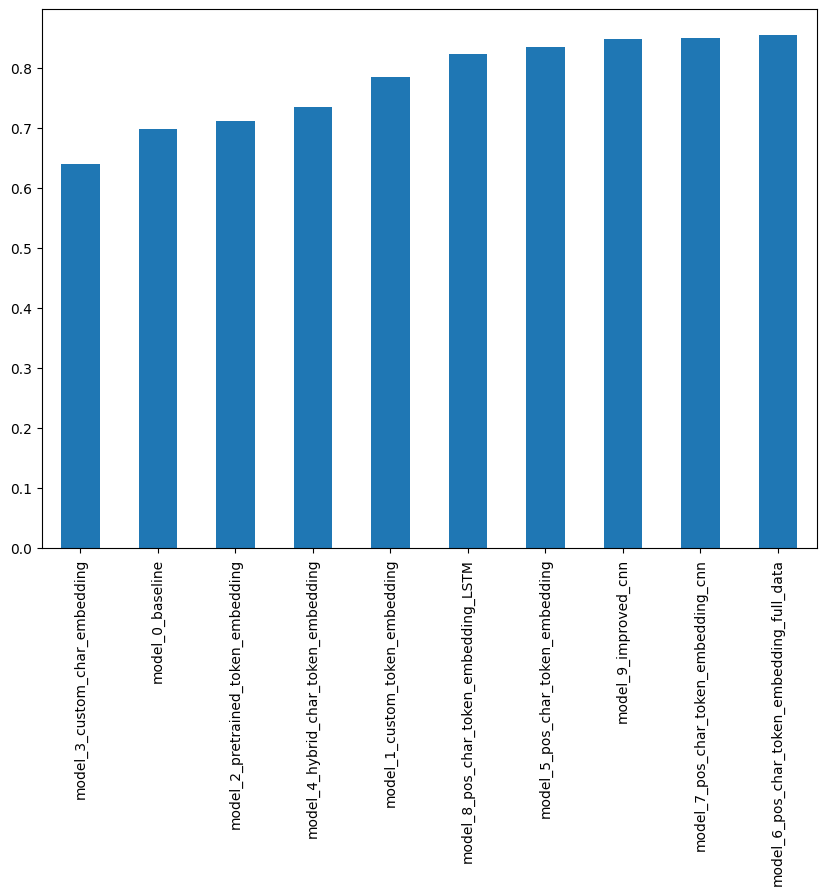

In [160]:
# Sort the model's results to score the models by f1-scores
all_model_results.sort_values("f1", ascending=True)["f1"].plot(kind="bar", figsize=(10,7))

## Saving the best performing model

We can save our best performing model which is `model_7`

In [161]:
# !mkdir "skimlit_full_model"

In [162]:
model_7.save("skimlit_full_model_cnn/loaded_model_format")

In [163]:
#zipping the model
!zip -r skimlit_full_model_cnn.zip skimlit_full_model_cnn/ 

  adding: skimlit_full_model_cnn/ (stored 0%)
  adding: skimlit_full_model_cnn/loaded_model_format/ (stored 0%)
  adding: skimlit_full_model_cnn/loaded_model_format/saved_model.pb (deflated 85%)
  adding: skimlit_full_model_cnn/loaded_model_format/fingerprint.pb (stored 0%)
  adding: skimlit_full_model_cnn/loaded_model_format/assets/ (stored 0%)
  adding: skimlit_full_model_cnn/loaded_model_format/variables/ (stored 0%)
  adding: skimlit_full_model_cnn/loaded_model_format/variables/variables.index (deflated 70%)
  adding: skimlit_full_model_cnn/loaded_model_format/variables/variables.data-00000-of-00001 (deflated 40%)
  adding: skimlit_full_model_cnn/loaded_model_format/keras_metadata.pb (deflated 92%)


In [164]:
#loadin the model and evaluating on the val_data
# loaded_model = tf.keras.models.load_model("skimlit_full_model/loaded_model_format")
# loaded_model.evaluate(val_char_token_pos_dataset)

In [165]:
#saving model in .keras format
# model_6.save("skimlit_full_model/skimlit_full_model.keras")

Let's

1. Turn the test data samples into tf.data Dataset(for fast loading) and make predictions on the best performing model on the test sample
2. Find the most wrong predictions from 1 (these are the samples where the modelhas predicted the wrong label with highest probability)
3. Make example predictions on RCT abstracts.


In [166]:
val_char_token_pos_dataset

<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [167]:
#creating a function to split document into sentences
def split_sentences(text):
    return text.split('. ')

#creating a function to return the position of the sentence
def position(sentence_list):
    index_list = []
    for index, sentence in enumerate(sentence_list):
        index_list.append(index)
    return index_list

In [168]:
sample_prediction_text = "Nutritional support of surgical and critically ill patients has undergone significant advances since 1936 when Studley demonstrated a direct relationship between pre-operative weight loss and operative mortality. The advent of total parenteral nutrition followed by the extraordinary progress in parenteral and enteral feedings, in addition to the increased knowledge of cellular biology and biochemistry, have allowed clinicians to treat malnutrition and improve surgical patient's outcomes. We reviewed the literature for the current status of perioperative nutrition comparing parenteral nutrition with enteral nutrition. In a surgical patient with established malnutrition, nutritional support should begin at least 7-10 days prior to surgery. Those patients in whom eating is not anticipated beyond the first five days following surgery should receive the benefits of early enteral or parenteral feeding depending on whether the gut can be used. Compared to parenteral nutrition, enteral nutrition is associated with fewer complications, a decrease in the length of hospital stay, and a favorable cost-benefit analysis. In addition, many patients may benefit from newer enteral formulations such as Immunonutrition as well as disease-specific formulations."

sample_sentence = split_sentences(sample_prediction_text)
position_list = position(sample_sentence)
print(position_list)

[0, 1, 2, 3, 4, 5, 6]


In [169]:
pos = tf.one_hot(position_list, depth=15)

In [170]:
# creating a function to covert the sentences to character tokens
def convert_char_tokens(sentence_list):
    char_list = []
    for token in sentence_list:
        char_list.append(" ".join(list(token)))

    return char_list

In [171]:
chars = convert_char_tokens(sample_sentence)
chars

['N u t r i t i o n a l   s u p p o r t   o f   s u r g i c a l   a n d   c r i t i c a l l y   i l l   p a t i e n t s   h a s   u n d e r g o n e   s i g n i f i c a n t   a d v a n c e s   s i n c e   1 9 3 6   w h e n   S t u d l e y   d e m o n s t r a t e d   a   d i r e c t   r e l a t i o n s h i p   b e t w e e n   p r e - o p e r a t i v e   w e i g h t   l o s s   a n d   o p e r a t i v e   m o r t a l i t y',
 "T h e   a d v e n t   o f   t o t a l   p a r e n t e r a l   n u t r i t i o n   f o l l o w e d   b y   t h e   e x t r a o r d i n a r y   p r o g r e s s   i n   p a r e n t e r a l   a n d   e n t e r a l   f e e d i n g s ,   i n   a d d i t i o n   t o   t h e   i n c r e a s e d   k n o w l e d g e   o f   c e l l u l a r   b i o l o g y   a n d   b i o c h e m i s t r y ,   h a v e   a l l o w e d   c l i n i c i a n s   t o   t r e a t   m a l n u t r i t i o n   a n d   i m p r o v e   s u r g i c a l   p a t i e n t ' s   o u t c o m e s",
 'W e   r e v 

In [172]:
train_line_numbers_one_hot, train_total_lines_one_hot

(<tf.Tensor: shape=(180040, 15), dtype=float32, numpy=
 array([[1., 0., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>,
 <tf.Tensor: shape=(180040, 20), dtype=float32, numpy=
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>)

In [173]:
#creating a function to get the total lines
def get_total_lines(text):
    total_abstract_lines = []
    for sentence in text.split('. '):
        total_abstract_lines.append(len(text.split('. ')))
        
    return total_abstract_lines

total_lines = tf.one_hot(get_total_lines(sample_prediction_text), depth=20)

In [174]:
pred_probs = model_6.predict((pos,
    total_lines,
    tf.constant(sample_sentence),
    tf.constant(chars)))

1/1 [==============================] - 3s 3s/step


In [175]:
# Checking the classes of the target variable
label_encoder.classes_

array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
      dtype=object)

In [176]:
# creating a list of target classes to index the pred probs array
target_classes = ['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS']

In [177]:
preds = tf.argmax(pred_probs, axis=1)
preds

<tf.Tensor: shape=(7,), dtype=int64, numpy=array([0, 0, 0, 2, 2, 4, 1])>

In [178]:
pred_classes = [target_classes[i] for i in preds]
pred_classes

['BACKGROUND',
 'BACKGROUND',
 'BACKGROUND',
 'METHODS',
 'METHODS',
 'RESULTS',
 'CONCLUSIONS']

In [179]:
#creating a dictionary to store predictions
prediction_dict = dict()
#visualizing the prediction
for i, line in enumerate(sample_sentence):
    print(f"{pred_classes[i]}: {line}\n")
    if pred_classes[i] in prediction_dict:
        prediction_dict[pred_classes[i]] = prediction_dict[pred_classes[i]] +". "+line
    else:
        prediction_dict[pred_classes[i]] = line

BACKGROUND: Nutritional support of surgical and critically ill patients has undergone significant advances since 1936 when Studley demonstrated a direct relationship between pre-operative weight loss and operative mortality

BACKGROUND: The advent of total parenteral nutrition followed by the extraordinary progress in parenteral and enteral feedings, in addition to the increased knowledge of cellular biology and biochemistry, have allowed clinicians to treat malnutrition and improve surgical patient's outcomes

BACKGROUND: We reviewed the literature for the current status of perioperative nutrition comparing parenteral nutrition with enteral nutrition

METHODS: In a surgical patient with established malnutrition, nutritional support should begin at least 7-10 days prior to surgery

METHODS: Those patients in whom eating is not anticipated beyond the first five days following surgery should receive the benefits of early enteral or parenteral feeding depending on whether the gut can be u

In [180]:
prediction_dict

{'BACKGROUND': "Nutritional support of surgical and critically ill patients has undergone significant advances since 1936 when Studley demonstrated a direct relationship between pre-operative weight loss and operative mortality. The advent of total parenteral nutrition followed by the extraordinary progress in parenteral and enteral feedings, in addition to the increased knowledge of cellular biology and biochemistry, have allowed clinicians to treat malnutrition and improve surgical patient's outcomes. We reviewed the literature for the current status of perioperative nutrition comparing parenteral nutrition with enteral nutrition",
 'METHODS': 'In a surgical patient with established malnutrition, nutritional support should begin at least 7-10 days prior to surgery. Those patients in whom eating is not anticipated beyond the first five days following surgery should receive the benefits of early enteral or parenteral feeding depending on whether the gut can be used',
 'RESULTS': 'Compa

In [181]:
for (key, value) in prediction_dict.items():
    print(f"{key}\n{value}\n")

BACKGROUND
Nutritional support of surgical and critically ill patients has undergone significant advances since 1936 when Studley demonstrated a direct relationship between pre-operative weight loss and operative mortality. The advent of total parenteral nutrition followed by the extraordinary progress in parenteral and enteral feedings, in addition to the increased knowledge of cellular biology and biochemistry, have allowed clinicians to treat malnutrition and improve surgical patient's outcomes. We reviewed the literature for the current status of perioperative nutrition comparing parenteral nutrition with enteral nutrition

METHODS
In a surgical patient with established malnutrition, nutritional support should begin at least 7-10 days prior to surgery. Those patients in whom eating is not anticipated beyond the first five days following surgery should receive the benefits of early enteral or parenteral feeding depending on whether the gut can be used

RESULTS
Compared to parenteral

In [182]:
# Combining the functions to generate a single tensor with position, total_lines, sentences, characters
def generate_tensor_from_text(text):
    sentence_list = split_sentences(text)
    position_list = position(sentence_list)
    characters = convert_char_tokens(sentence_list)
    total_lines = get_total_lines(text)
    
    position_encoded = tf.one_hot(position_list, depth=15)
    
    total_lines_encoded = tf.one_hot(total_lines, depth=20)
    return (position_encoded, total_lines_encoded, tf.constant(sentence_list), tf.constant(characters))

In [183]:
sample_2 = "\"The doctor of the future will no longer treat the human frame with drugs, but will rather cure and prevent disease with nutrition\". Thomas Edison's contemplation may come to fruition if the nutritional revolution continues in its current course. Two realizations have propelled the world into a new age of personalized nutrition: (i) food can provide benefits beyond its intrinsic nutrient content, and (ii) we are not all created equal in our ability to realize to these benefits. Nutrigenomics is concerned with delineating genomic propensities to respond to various nutritional stimuli and the resulting impact on individual health. This review will examine the current technologies utilized by nutrigeneticists, the available literature regarding nutrient-gene interactions, and the translation of this new awareness into public health."


In [184]:
sample_tensor_2 = generate_tensor_from_text(sample_2)


In [185]:
probs = model_6.predict(sample_tensor_2)

1/1 [==============================] - 0s 34ms/step


In [186]:
def generate_results_from_probs(probs, text):
    target_classes = ['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS']
    preds = tf.argmax(pred_probs, axis=1)
    pred_classes = [target_classes[i] for i in preds]
    #creating a dictionary to store predictions
    prediction_dict = dict()
    sentence_list = split_sentences(text)
    #visualizing the prediction
    for i, line in enumerate(sentence_list):
        print(f"{pred_classes[i]}: {line}\n")
        if pred_classes[i] in prediction_dict:
            prediction_dict[pred_classes[i]] = prediction_dict[pred_classes[i]] +". "+line
        else:
            prediction_dict[pred_classes[i]] = line
    return prediction_dict

In [187]:
pred_2 = generate_results_from_probs(probs, sample_2)

BACKGROUND: "The doctor of the future will no longer treat the human frame with drugs, but will rather cure and prevent disease with nutrition"

BACKGROUND: Thomas Edison's contemplation may come to fruition if the nutritional revolution continues in its current course

BACKGROUND: Two realizations have propelled the world into a new age of personalized nutrition: (i) food can provide benefits beyond its intrinsic nutrient content, and (ii) we are not all created equal in our ability to realize to these benefits

METHODS: Nutrigenomics is concerned with delineating genomic propensities to respond to various nutritional stimuli and the resulting impact on individual health

METHODS: This review will examine the current technologies utilized by nutrigeneticists, the available literature regarding nutrient-gene interactions, and the translation of this new awareness into public health.



In [188]:
pred_2

{'BACKGROUND': '"The doctor of the future will no longer treat the human frame with drugs, but will rather cure and prevent disease with nutrition". Thomas Edison\'s contemplation may come to fruition if the nutritional revolution continues in its current course. Two realizations have propelled the world into a new age of personalized nutrition: (i) food can provide benefits beyond its intrinsic nutrient content, and (ii) we are not all created equal in our ability to realize to these benefits',
 'METHODS': 'Nutrigenomics is concerned with delineating genomic propensities to respond to various nutritional stimuli and the resulting impact on individual health. This review will examine the current technologies utilized by nutrigeneticists, the available literature regarding nutrient-gene interactions, and the translation of this new awareness into public health.'}